<a href="https://colab.research.google.com/github/kishore-n-george/telecom-churn/blob/main/telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
## Objectives
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

Recommend strategies to manage customer churn based on your observations.



In [241]:
!pip install statsmodels
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install plotly

Re-Usable Functions

In [242]:
def calculate_metrics(train,pred):
  """ Calculates important metrics for a given train and predictions"""
  metrics=[]
  r2 = r2_score(train, pred)
  metrics.append(r2)
  print("R2 Score is:", r2)
  rss = np.sum(np.square(train - pred))
  metrics.append(rss)
  print("RSS is ", rss)
  mse = mean_squared_error(train, pred)
  metrics.append(mse)
  print("MSE is: ", mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  metrics.append(rmse)
  print("RMSE is: ", rmse)
  return metrics

def run_cross_validation(model, params, X_train,y_train,scoring= 'neg_mean_absolute_error'):
  """ Runs Cross validation for the model passed with params"""
  # cross validation
  modelCV = GridSearchCV(estimator = model, 
                          param_grid = params, 
                          scoring= scoring,  
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1, n_jobs=-1)            
  modelCV.fit(X_train, y_train) 

  print(modelCV.best_params_)
  return modelCV

def do_residual_analysis(y_train, y_train_pred):
  """Does residual analysis and plots residuals"""
  y_res = y_train - y_train_pred
  #y_res
  data = pd.DataFrame({"res":y_res})
  plt.scatter( y_train_pred , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel("Predictions")
  plt.ylabel("Residual")
  plt.show()

# Distribution of errors
  p = sns.distplot(y_res,kde=True)

  p = plt.title('Normality of error terms/residuals')
  plt.xlabel("Residuals")
  plt.show()

def print_metrics(ridge_metrics, lasso_metrics, col1, col2):
  """Print metrics in comparable tabular format"""
  ## Setting float display options
  pd.options.display.float_format = "{:,.2f}".format
  # Creating a table which contain all the metrics
  lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                        'MSE (Train)', 'RMSE (Train)', 'R2 Score (Test)','RSS (Test)',
                        'MSE (Test)', 'RMSE (Test)'],
              col1 : ridge_metrics,
              col2 : lasso_metrics }

  final_metric = pd.DataFrame(lr_table, columns = ['Metric', col1,col2] )
  final_metric.set_index('Metric')
  print(final_metric)




# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [243]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [244]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
# PCA
from sklearn.decomposition import PCA
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
# logistic regression
from sklearn.linear_model import LogisticRegression
# for charting
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls


Loading Data

In [245]:
telecom = pd.read_csv("./data/train.csv")

In [246]:
# Check the head of the dataset
telecom.head()

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7  ...  sachet_3g_7  sachet_3g_8  fb_user_6  fb_user_7  fb_user_8  \
0   87.009  ...            0            0        NaN        NaN        NaN   
1  122.787  ...            0            0        NaN        1.0        NaN   
2  103.176  ...            0            0        NaN        NaN        NaN   
3  205.260  ...            0            0        NaN        NaN        NaN   
4  128.191  ...            1            0        1.0        1.0        1.0   

    aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  churn_probability  
0  1958         0.0         0.0         0.0                  0  
1   710         0.0         0.0         0.0                  0  
2   882         0.0         0.0         0.0                  0  
3   982         0.0         0.0         0.0                  0  
4   647         0.0         0.0         0.0                  0  

[5 rows x 172 columns]

Inspect the various aspects of the dataframe

In [247]:
telecom.shape
# Inference - 34897 Rows, 172 Columns

(69999, 172)

In [248]:
telecom.info(verbose=True, show_counts=True)
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

Check for duplicates

In [249]:
# check for duplicate rows based on id
any_duplicates=telecom.duplicated(['id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [250]:
# remove empty columns
telecom = telecom.dropna(axis = 1, how = 'all')
telecom.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        69999 non-null  int64  
 1    circle_id                 69999 non-null  int64  
 2    loc_og_t2o_mou            69297 non-null  float64
 3    std_og_t2o_mou            69297 non-null  float64
 4    loc_ic_t2o_mou            69297 non-null  float64
 5    last_date_of_month_6      69999 non-null  object 
 6    last_date_of_month_7      69600 non-null  object 
 7    last_date_of_month_8      69266 non-null  object 
 8    arpu_6                    69999 non-null  float64
 9    arpu_7                    69999 non-null  float64
 10   arpu_8                    69999 non-null  float64
 11   onnet_mou_6               67231 non-null  float64
 12   onnet_mou_7               67312 non-null  float64
 13   onnet_mou_8               66296 non-null  fl

Drop rows with NA

In [251]:
#drop all the rows with only nan values
telecom = telecom.dropna(axis = 0, how = 'all')
telecom.info()
# no of rows remains 34897

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 92.4+ MB


Data Imputation
- Dropping columns with high percentage of NA removes some important columns
- So, impute before dropping columns

In [252]:
rech_col = [col for col in telecom.columns if 'rech' in col and 'date' not in col]
print(rech_col)

for col in rech_col:
  print(col)
  print('Before Cleaning')
  print(telecom[col].isnull().sum())
  telecom[col].fillna(0,inplace=True)
  print('After Cleaning')
  print(telecom[col].isnull().sum())
# for these columns, imputing NA with 0 makes sense.


['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
total_rech_num_6
Before Cleaning
0
After Cleaning
0
total_rech_num_7
Before Cleaning
0
After Cleaning
0
total_rech_num_8
Before Cleaning
0
After Cleaning
0
total_rech_amt_6
Before Cleaning
0
After Cleaning
0
total_rech_amt_7
Before Cleaning
0
After Cleaning
0
total_rech_amt_8
Before Cleaning
0
After Cleaning
0
max_rech_amt_6
Before Cleaning
0
After Cleaning
0
max_rech_amt_7
Before Cleaning
0
After Cleaning
0
max_rech_amt_8
Before Cleaning
0
After Cleaning
0
total_rech_data_6
Before Cleaning
52431
After Cleaning
0
total_

Drop columns that high percentage of Nan

In [253]:
#drop columns that have high percentage of nan
print(telecom.shape)
# keep columns where null percentage is less than 60%
telecom = telecom.loc[:, telecom.isnull().mean() < .6]
# 15 columns with high percentage of nulls dropped
print(telecom.shape)

(69999, 172)
(69999, 157)


Drop rows with high percentage of Nan

In [254]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*telecom.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
telecom = telecom.dropna( axis=0, 
                    thresh=min_count)
telecom.shape
# 18 rows dropped.

63


(69969, 157)

Data Manipulation

In [255]:
telecom.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69969 entries, 0 to 69998
Data columns (total 157 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    69969 non-null  int64  
 1    circle_id             69969 non-null  int64  
 2    loc_og_t2o_mou        69297 non-null  float64
 3    std_og_t2o_mou        69297 non-null  float64
 4    loc_ic_t2o_mou        69297 non-null  float64
 5    last_date_of_month_6  69969 non-null  object 
 6    last_date_of_month_7  69600 non-null  object 
 7    last_date_of_month_8  69266 non-null  object 
 8    arpu_6                69969 non-null  float64
 9    arpu_7                69969 non-null  float64
 10   arpu_8                69969 non-null  float64
 11   onnet_mou_6           67231 non-null  float64
 12   onnet_mou_7           67312 non-null  float64
 13   onnet_mou_8           66296 non-null  float64
 14   offnet_mou_6          67231 non-null  float64
 15   

Print all columns with missing values

In [256]:
def print_cols_with_missing_values():
  pd.set_option('display.max_rows', None)
  cols_with_missing_values = telecom.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  pd.reset_option('display.max_rows')

print_cols_with_missing_values()

Number of Missing Values
loc_og_t2c_mou_8                          3673
isd_og_mou_8                              3673
std_ic_t2m_mou_8                          3673
std_og_t2m_mou_8                          3673
loc_og_mou_8                              3673
std_og_t2f_mou_8                          3673
std_ic_t2t_mou_8                          3673
loc_og_t2f_mou_8                          3673
std_ic_t2f_mou_8                          3673
std_og_t2c_mou_8                          3673
loc_og_t2m_mou_8                          3673
loc_og_t2t_mou_8                          3673
std_og_mou_8                              3673
roam_og_mou_8                             3673
std_ic_t2o_mou_8                          3673
roam_ic_mou_8                             3673
loc_ic_mou_8                              3673
loc_ic_t2f_mou_8                          3673
og_others_8                               3673
ic_others_8                               3673
loc_ic_t2t_mou_8                          3673
loc_ic_t2m_mou_8                          3673
isd_ic_mou_8                              3673
spl_ic_mou_8                              3673
offnet_mou_8                              3673
std_og_t2t_mou_8                          3673
std_ic_mou_8                              3673
onnet_mou_8                               3673
spl_og_mou_8                              3673
std_ic_t2t_mou_6                          2738
std_og_mou_6                              2738
loc_ic_mou_6                              2738
isd_og_mou_6                              2738
loc_ic_t2f_mou_6                          2738
loc_ic_t2t_mou_6                          2738
std_og_t2c_mou_6                          2738
std_ic_t2m_mou_6                          2738
std_og_t2f_mou_6                          2738
og_others_6                               2738
std_og_t2m_mou_6                          2738
spl_og_mou_6                              2738
loc_ic_t2m_mou_6                          2738
std_ic_mou_6                              2738
loc_og_t2m_mou_6                          2738
onnet_mou_6                               2738
offnet_mou_6                              2738
isd_ic_mou_6                              2738
roam_ic_mou_6                             2738
std_og_t2t_mou_6                          2738
roam_og_mou_6                             2738
loc_og_t2t_mou_6                          2738
spl_ic_mou_6                              2738
std_ic_t2o_mou_6                          2738
loc_og_t2f_mou_6                          2738
loc_og_t2c_mou_6                          2738
ic_others_6                               2738
loc_og_mou_6                              2738
std_ic_t2f_mou_6                          2738
spl_ic_mou_7                              2657
ic_others_7                               2657
loc_ic_t2f_mou_7                          2657
isd_ic_mou_7                              2657
std_ic_t2m_mou_7                          2657
std_ic_mou_7                              2657
loc_ic_mou_7                              2657
std_ic_t2o_mou_7                          2657
std_ic_t2f_mou_7                          2657
loc_ic_t2m_mou_7                          2657
std_ic_t2t_mou_7                          2657
isd_og_mou_7                              2657
loc_ic_t2t_mou_7                          2657
std_og_t2m_mou_7                          2657
onnet_mou_7                               2657
offnet_mou_7                              2657
roam_og_mou_7                             2657
loc_og_t2t_mou_7                          2657
loc_og_t2m_mou_7                          2657
loc_og_t2f_mou_7                          2657
loc_og_t2c_mou_7                          2657
loc_og_mou_7                              2657
std_og_t2t_mou_7                          2657
roam_ic_mou_7                             2657
std_og_t2f_mou_7                          2657
std_og_t2c_mou_7                          2657
std_og_mou_7               

Data Cleaning
- columns with only one value - drop
- derive aggregate measures using date columns
- date columns marks only the last day of month - can be dropped?
- check every column which has nulls
- fix nulls
- impute data where required

In [257]:
pd.set_option('display.max_rows', None)
print(telecom.dtypes)
pd.reset_option('display.max_rows')

# inference
# - only float and int columns
# - object columns could be converted to datetime and extracted if needed.

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

Deleting columns that add no value

In [258]:
# Check columns for only 1 unique value
drop_col = []

for col in telecom.columns:
    if telecom[f'{col}'].nunique() == 1:
        drop_col.append(col)

print(drop_col)
# Drop single value columns
print(telecom.shape)
telecom.drop(drop_col, axis=1, inplace=True)
print(telecom.shape)
# dropped 13 columns

# drop column id
# telecom.drop('id', axis=1, inplace=True)
# print(telecom.shape)

# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in telecom.columns if 'date' in col]
telecom.drop(date_col, axis=1, inplace=True)
print(telecom.shape)


['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
(69969, 157)
(69969, 144)
(69969, 141)


Drop highly correlated columns

In [259]:
# plot correlation
#plt.figure(figsize = (25,20))
#sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
#plt.show()

In [260]:
def find_corr_columns():
  cor_matrix = telecom.corr().abs()
  print(cor_matrix)
  # Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. 
  # So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  print(upper_tri)
  # selecting columns that have corr > 0.9
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
  print(to_drop)
  return to_drop

find_corr_columns()
# Inference
# - before dropping rech columns, let us derive some metrics from the rech columns

                         id    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
id                 1.000000  0.000171  0.003565  0.003824     0.002825   
arpu_6             0.000171  1.000000  0.743914  0.643347     0.446970   
arpu_7             0.003565  0.743914  1.000000  0.782272     0.321567   
arpu_8             0.003824  0.643347  0.782272  1.000000     0.245615   
onnet_mou_6        0.002825  0.446970  0.321567  0.245615     1.000000   
...                     ...       ...       ...       ...          ...   
aon                0.000678  0.025954  0.023843  0.033284     0.045107   
aug_vbc_3g         0.006759  0.168384  0.189884  0.224816     0.012440   
jul_vbc_3g         0.004031  0.184246  0.218266  0.177580     0.012149   
jun_vbc_3g         0.003073  0.217802  0.171108  0.157498     0.008332   
churn_probability  0.001553  0.025483  0.056896  0.156875     0.061830   

                   onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                    0.006291     0

['isd_og_mou_7',
 'isd_og_mou_8',
 'total_ic_mou_6',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8']

Derive Total recharge amount

In [261]:
# Though we have total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
# so let's calculate that amount
telecom['total_data_rech_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_data_rech_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_data_rech_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']

# Drop the columns already accounted for 
telecom.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

Derive specific columns for the last month (assuming user churns after this) - in this case the 8th month

In [262]:

# Seperating columns for the 8th month
mnth8_columns = [col for col in telecom.columns if '8' in col]
print(mnth8_columns)

# Seperating the ic columns 
mnth8_ic_columns = [col for col in mnth8_columns if 'ic' in col and 'mou' in col]
print(mnth8_ic_columns)

# Seperating oc columns
mnth8_oc_columns = [col for col in mnth8_columns if 'oc' in col and 'mou' in col]
print(mnth8_oc_columns)

# Seperating vol columns
mnth8_vol_columns = [col for col in mnth8_columns if 'vol' in col and 'mb' in col]
print(mnth8_vol_columns)

# Sum of all the ic columns
telecom['ic_sum'] = telecom[mnth8_ic_columns].sum(axis = 1)

# Sum of all the oc columns
telecom['oc_sum'] = telecom[mnth8_oc_columns].sum(axis = 1)

# Sum of all the vol columns
telecom['vol_sum'] = telecom[mnth8_vol_columns].sum(axis = 1)

churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values
telecom['churn_indicator'] = telecom[churn_tag_columns].sum(axis = 1)
# If the churn value is greater than 0 that means the user used a service indicating an active user
# 0 - no churn
# 1 - churn
telecom['churn_indicator'] = telecom['churn_indicator'].apply(lambda x: 0 if x > 0 else 1)

telecom.churn_indicator.value_counts(normalize=True)

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'total_data_rech_amt_8']
['roam_ic_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_

0    0.948534
1    0.051466
Name: churn_indicator, dtype: float64

In [263]:
telecom.head(5)

id   arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0   0   31.277   87.009    7.527        48.58       124.38         1.29   
1   1    0.000  122.787   42.953         0.00         0.00         0.00   
2   2   60.806  103.176    0.000         0.53        15.93         0.00   
3   3  156.362  205.260  111.095         7.26        16.01         0.00   
4   4  240.708  128.191  101.565        21.28         4.83         6.13   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  ...  jul_vbc_3g  jun_vbc_3g  \
0         32.24         96.68          2.33  ...         0.0         0.0   
1          0.00         25.99         30.89  ...         0.0         0.0   
2         53.99         82.05          0.00  ...         0.0         0.0   
3         68.76         78.48         50.23  ...         0.0         0.0   
4         56.99         38.11          9.63  ...         0.0         0.0   

   churn_probability  total_data_rech_amt_6  total_data_rech_amt_7  \
0                  0                    0.0                    0.0   
1                  0                    0.0                  145.0   
2                  0                    0.0                    0.0   
3                  0                    0.0                    0.0   
4                  0                 1225.0                 1337.0   

   total_data_rech_amt_8  ic_sum  oc_sum  vol_sum  churn_indicator  
0                    0.0  120.98   54.63     0.00                0  
1                    0.0   75.10   79.84     0.00                0  
2                    0.0  109.41   60.01     0.00                0  
3                    0.0  251.51  217.34     0.00                0  
4                  852.0   84.91   88.11   213.47                0  

[5 rows x 142 columns]

In [264]:
# Dropping month 8 columns
drop_cols = [ col for col in mnth8_columns + churn_tag_columns if col not in ['total_rech_data_8', 'av_rech_amt_data_8','total_data_rech_amt_8'] ]
print(drop_cols)
telecom.drop(drop_cols ,
                axis=1, inplace=True)

telecom.shape

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vol_sum', 'oc_sum', 'ic_sum']


(69969, 96)

Dropping highly correlated columns

In [265]:
drop_cols = find_corr_columns()
telecom.drop(drop_cols, axis=1, inplace=True)
telecom.shape

# six columns dropped

                             id    arpu_6    arpu_7  onnet_mou_6  onnet_mou_7  \
id                     1.000000  0.000171  0.003565     0.002825     0.006291   
arpu_6                 0.000171  1.000000  0.743914     0.446970     0.330179   
arpu_7                 0.003565  0.743914  1.000000     0.321567     0.426994   
onnet_mou_6            0.002825  0.446970  0.321567     1.000000     0.748947   
onnet_mou_7            0.006291  0.330179  0.426994     0.748947     1.000000   
...                         ...       ...       ...          ...          ...   
churn_probability      0.001553  0.025483  0.056896     0.061830     0.012085   
total_data_rech_amt_6  0.000450  0.193306  0.128250     0.009286     0.013762   
total_data_rech_amt_7  0.002096  0.125723  0.212342     0.003744     0.002969   
total_data_rech_amt_8  0.004856  0.106661  0.133220     0.008998     0.006898   
churn_indicator        0.001326  0.018564  0.099374     0.032147     0.031704   

                       offn

(69969, 90)

Deriving some more metrics

In [266]:
mou_columns = [col for col in telecom.columns if 'mou' in col]
mou_columns
# Create a total mou instead of offnet and onnet
telecom['total_mou_6'] = telecom['onnet_mou_6'] + telecom['offnet_mou_6']
telecom['total_mou_7'] = telecom['onnet_mou_7'] + telecom['offnet_mou_7']

telecom['total_mou_6'].fillna(0,inplace=True)
telecom['total_mou_7'].fillna(0,inplace=True)
# # Drop the redundant columns
telecom.drop(['onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7'], axis=1, inplace=True)
telecom.shape

(69969, 88)

In [267]:
telecom.describe()

id        arpu_6        arpu_7  roam_ic_mou_6  roam_ic_mou_7  \
count  69969.000000  69969.000000  69969.000000   67231.000000   67312.000000   
mean   34999.811902    283.143425    278.305187       9.765435       7.014568   
std    20206.873873    334.239594    344.392555      57.374429      55.960985   
min        0.000000  -2258.709000  -1289.715000       0.000000       0.000000   
25%    17501.000000     93.581000     86.810000       0.000000       0.000000   
50%    35002.000000    197.512000    191.729000       0.000000       0.000000   
75%    52497.000000    370.812000    365.441000       0.000000       0.000000   
max    69998.000000  27731.088000  35145.834000    2850.980000    4155.830000   

       roam_og_mou_6  roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   67231.000000   67312.000000      67231.000000      67312.000000   
mean       14.186457       9.842191         46.904854         46.166503   
std        73.469261      58.511894        150.971758        154.739002   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.650000   
50%         0.000000       0.000000         11.910000         11.580000   
75%         0.000000       0.000000         40.740000         39.760000   
max      3775.110000    2812.040000       6431.330000       7400.660000   

       loc_og_t2m_mou_6  ...    aug_vbc_3g    jul_vbc_3g    jun_vbc_3g  \
count      67231.000000  ...  69969.000000  69969.000000  69969.000000   
mean          93.238231  ...     68.137799     65.964100     60.099594   
std          162.046699  ...    269.382699    267.952981    257.278753   
min            0.000000  ...      0.000000      0.000000      0.000000   
25%            9.920000  ...      0.000000      0.000000      0.000000   
50%           41.030000  ...      0.000000      0.000000      0.000000   
75%          110.430000  ...      0.000000      0.000000      0.000000   
max         4696.830000  ...  12916.220000   9165.600000  11166.210000   

       churn_probability  total_data_rech_amt_6  total_data_rech_amt_7  \
count       69969.000000           69969.000000           69969.000000   
mean            0.101502             148.542879             172.598791   
std             0.301995             749.167015             856.784260   
min             0.000000               0.000000               0.000000   
25%             0.000000               0.000000               0.000000   
50%             0.000000               0.000000               0.000000   
75%             0.000000               8.000000              17.000000   
max             1.000000           55296.000000           55080.000000   

       total_data_rech_amt_8  churn_indicator   total_mou_6   total_mou_7  
count           69969.000000     69969.000000  69969.000000  69969.000000  
mean              174.320773         0.051466    319.035251    318.476625  
std               950.259271         0.220947    471.962673    483.567007  
min                 0.000000         0.000000      0.000000      0.000000  
25%                 0.000000         0.000000     52.020000     47.680000  
50%                 0.000000         0.000000    156.130000    147.430000  
75%                23.000000         0.000000    391.370000    390.950000  
max             89106.500000         1.000000  10673.280000   8235.710000  

[8 rows x 88 columns]

# Step 2: Visualising the Data
Let's now spend some time doing what is arguably the most important step - understanding the data.

If there is some obvious multicollinearity going on, this is the first place to catch it
Here's where you'll also identify if some predictors directly have a strong association with the outcome variable
We'll visualise our data using matplotlib and seaborn.

Visualize numerical columns


Index(['id', 'arpu_6', 'arpu_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7',
       'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6',
       'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_6',
       'spl_

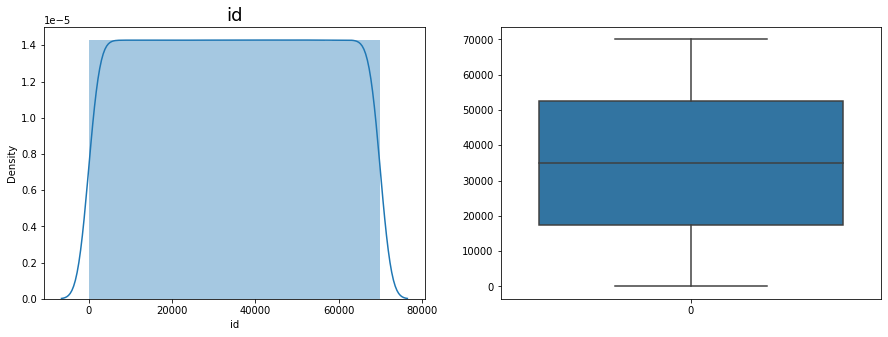

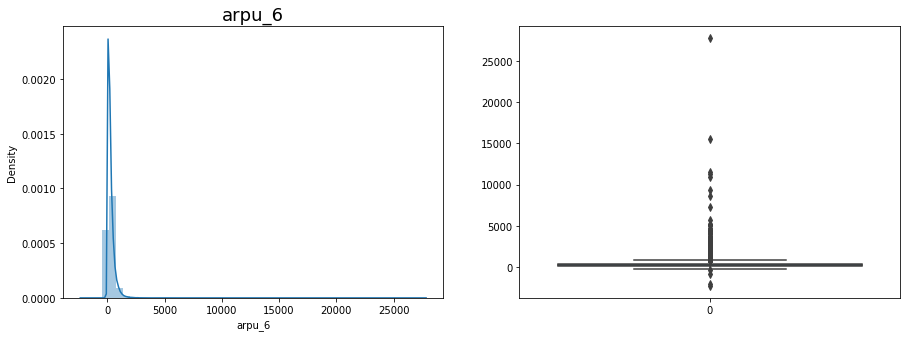

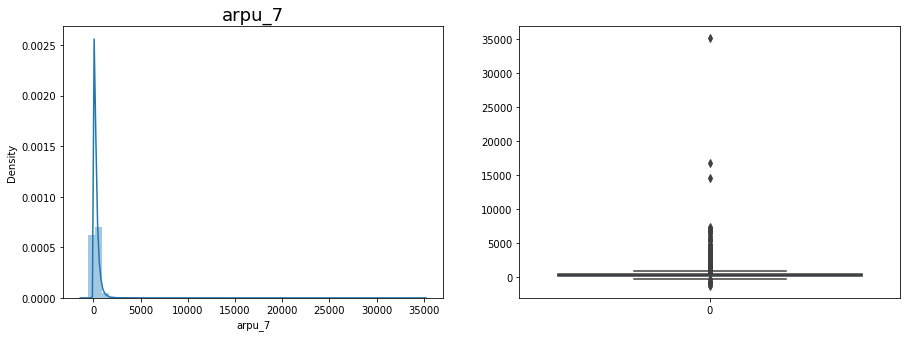

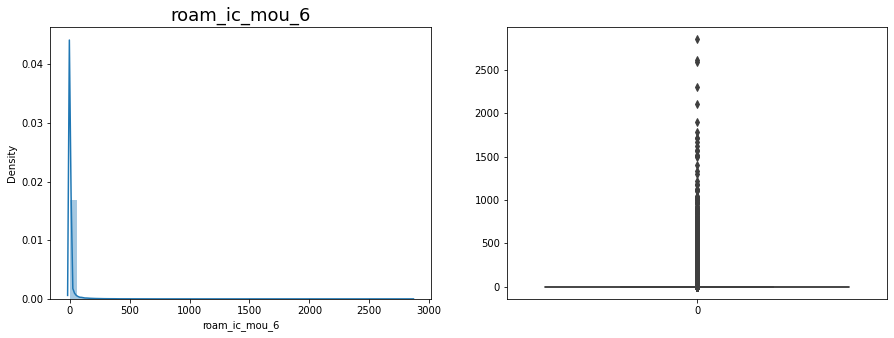

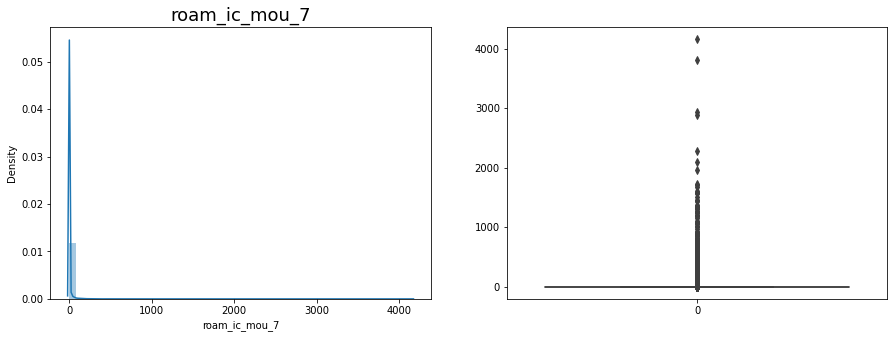

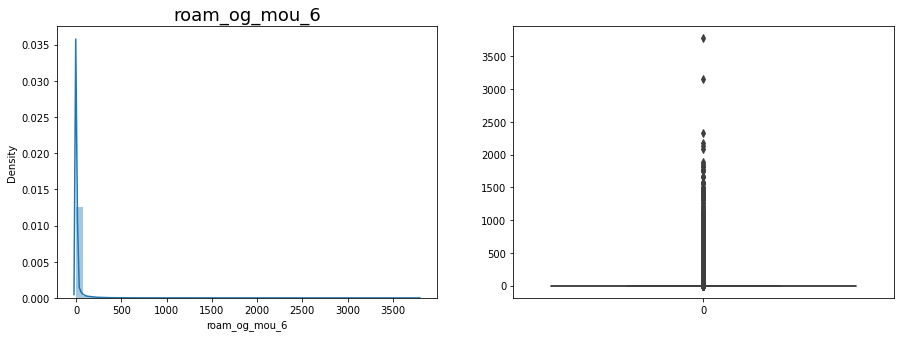

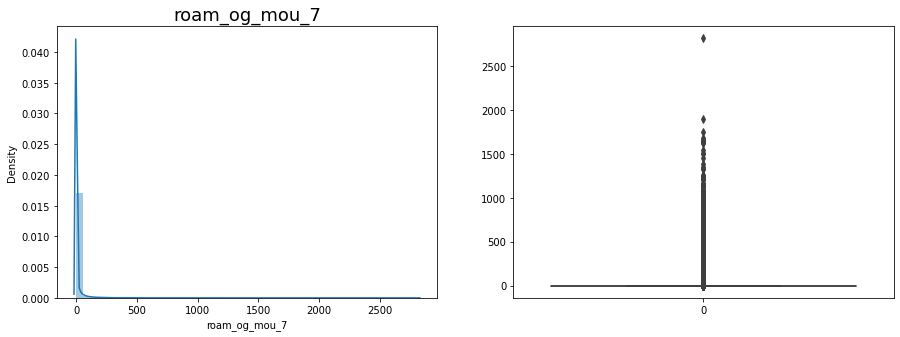

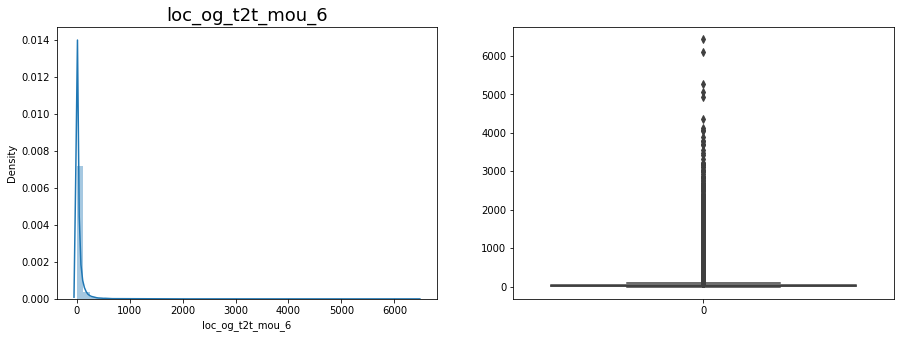

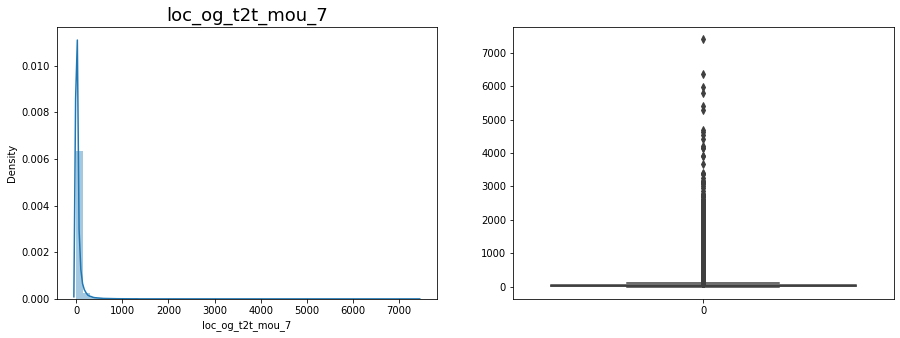

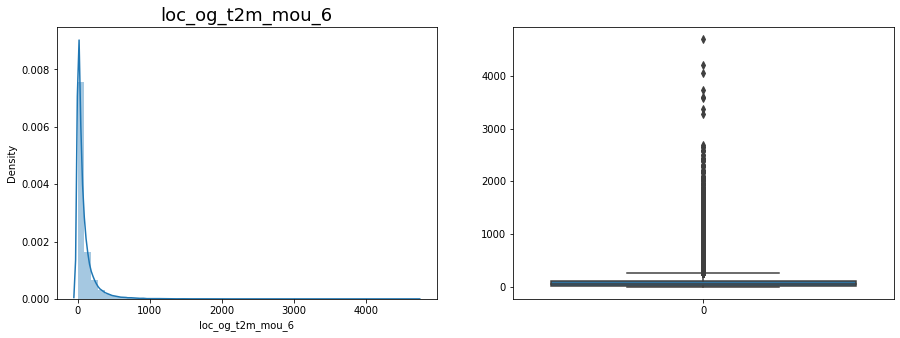

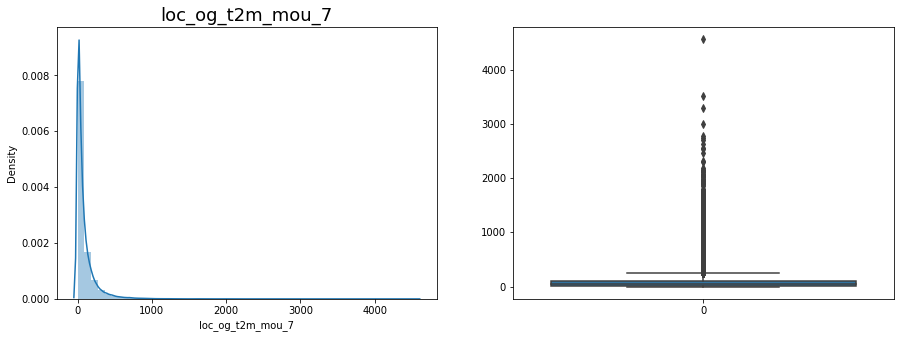

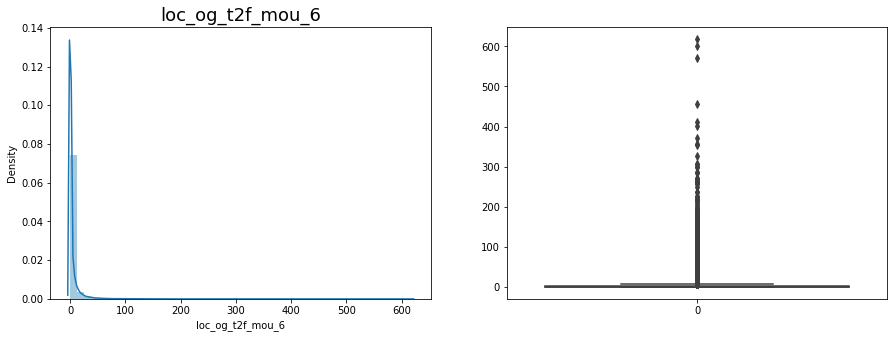

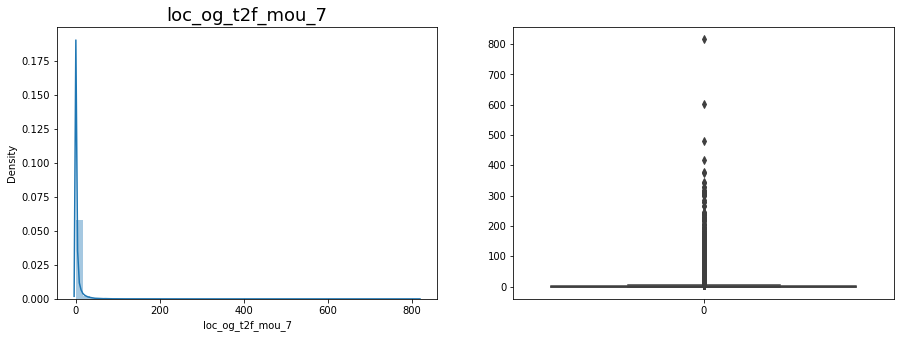

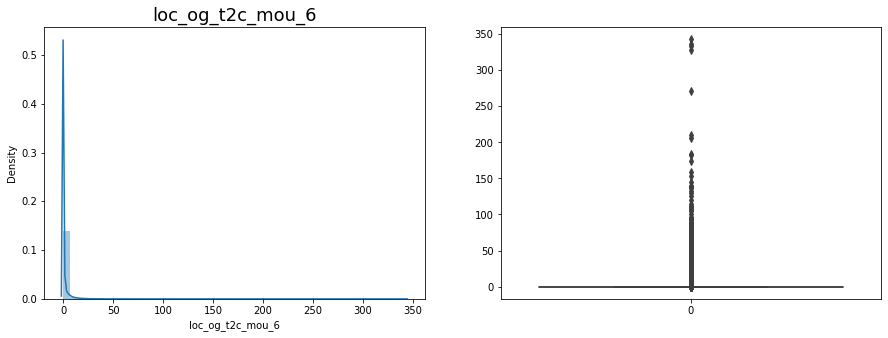

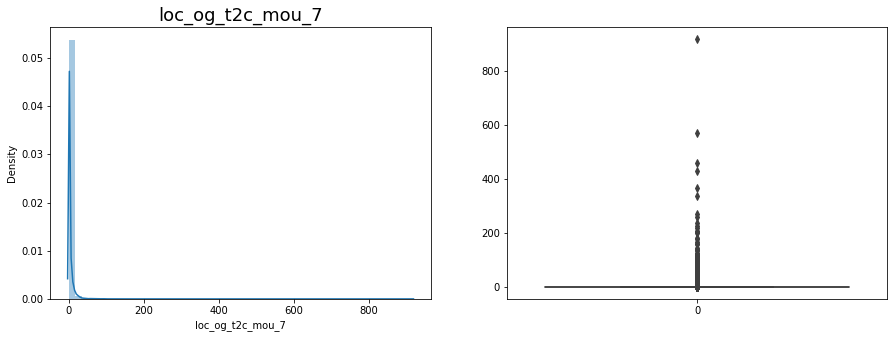

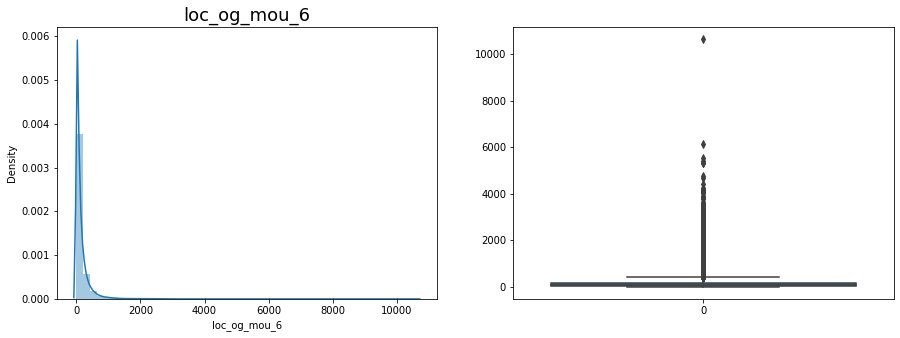

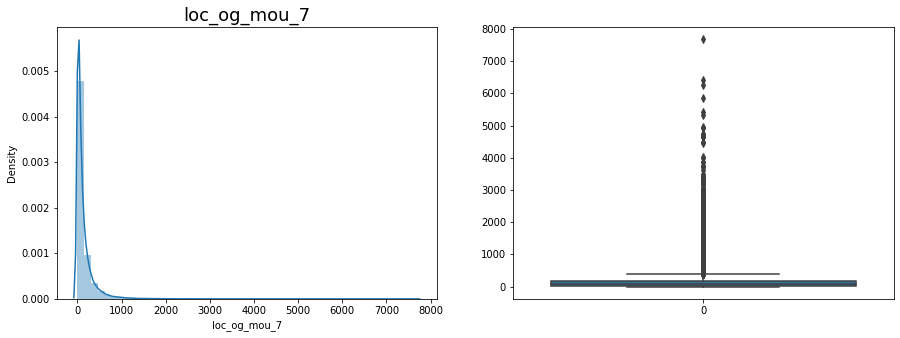

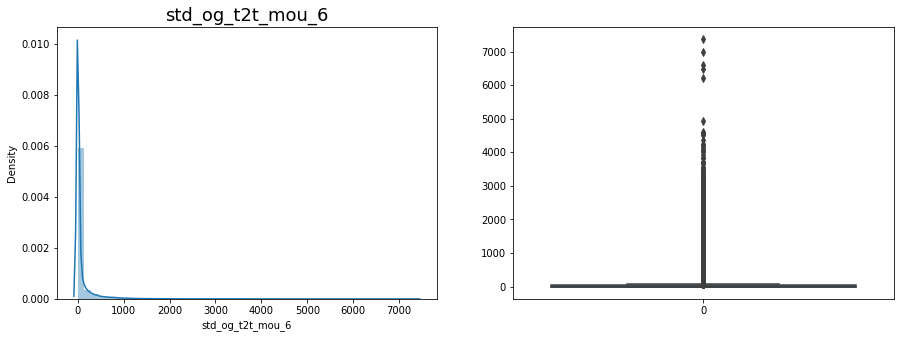

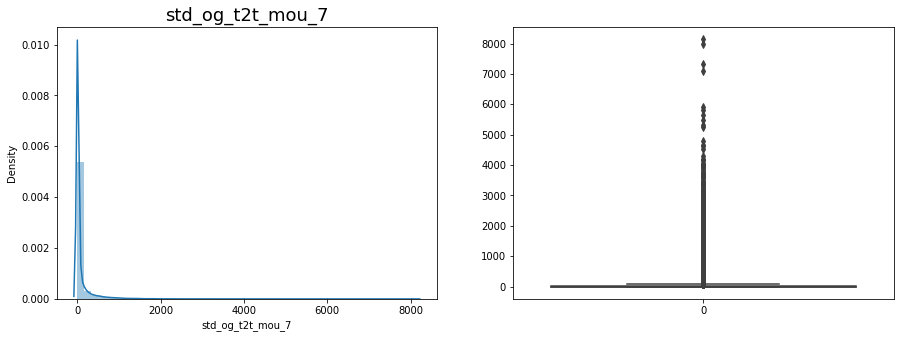

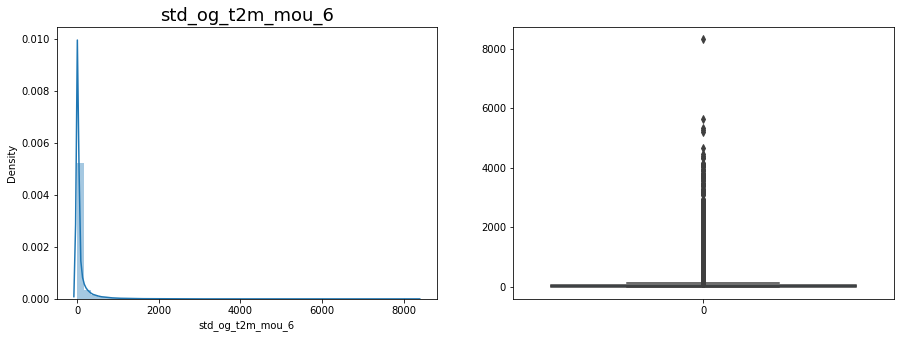

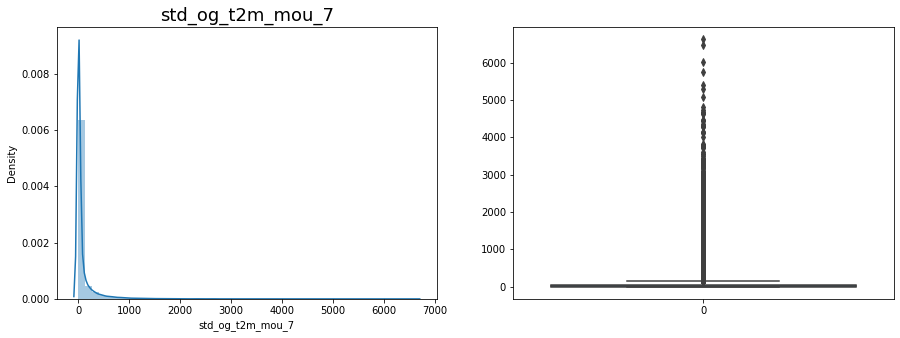

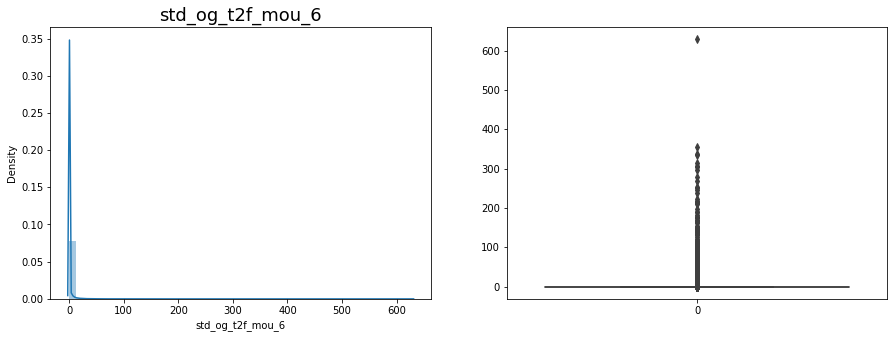

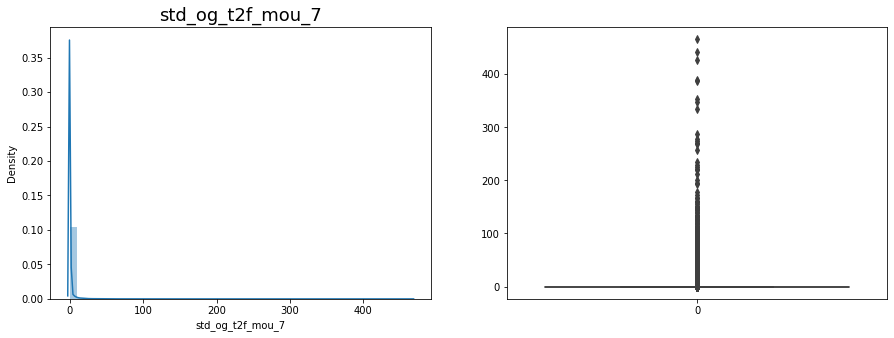

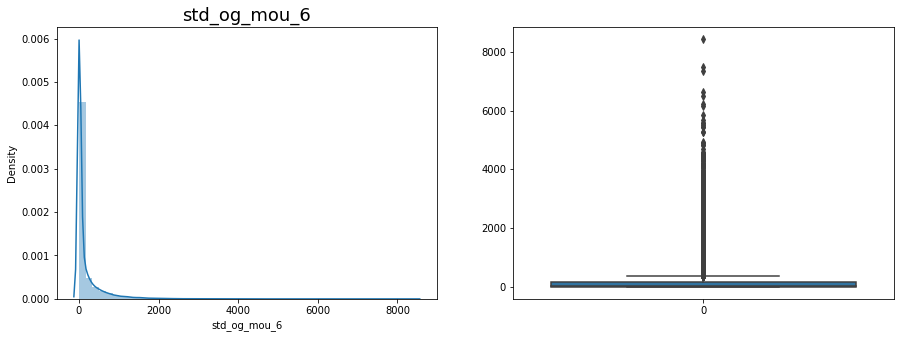

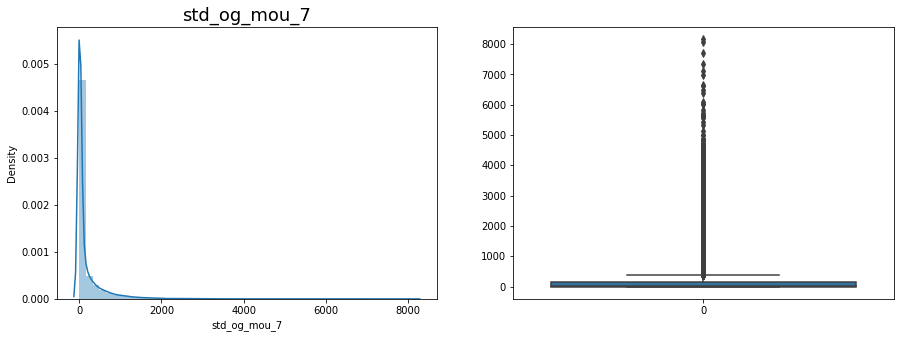

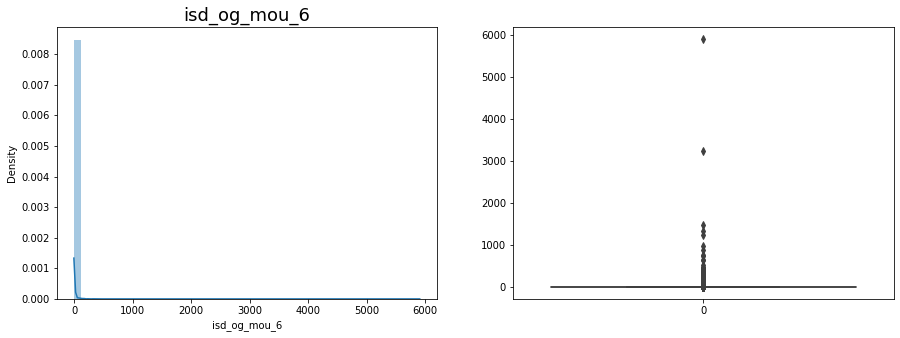

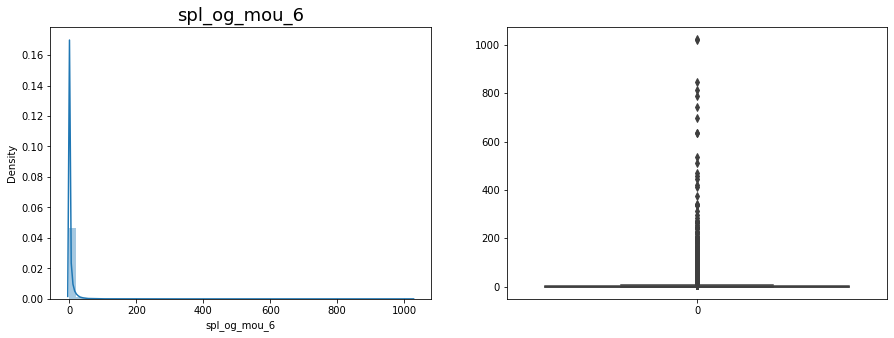

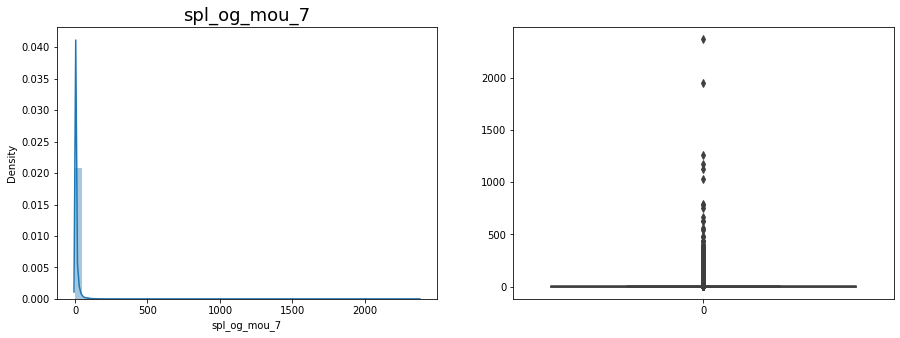

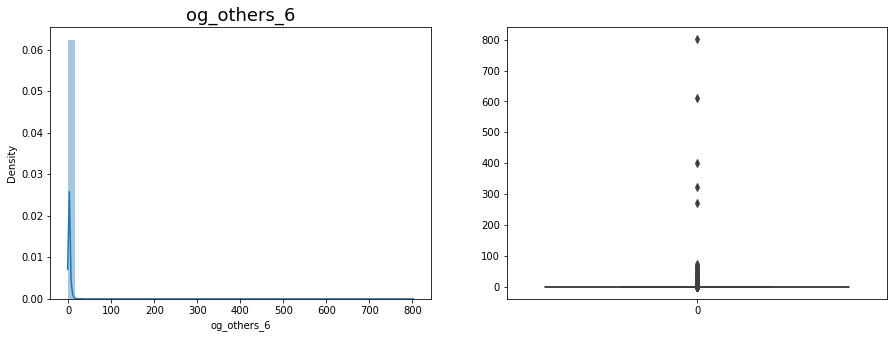

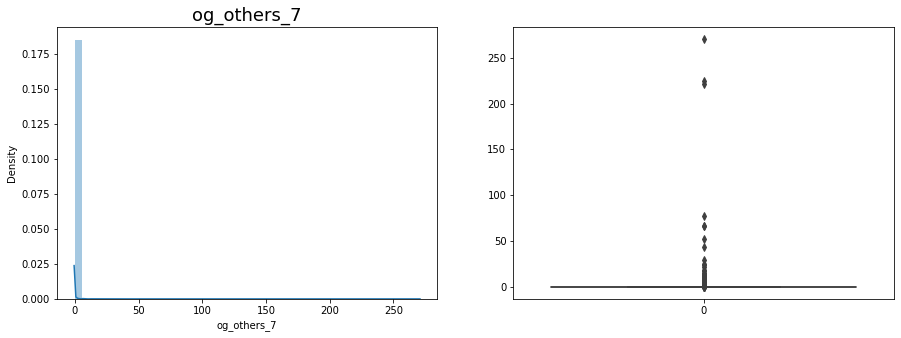

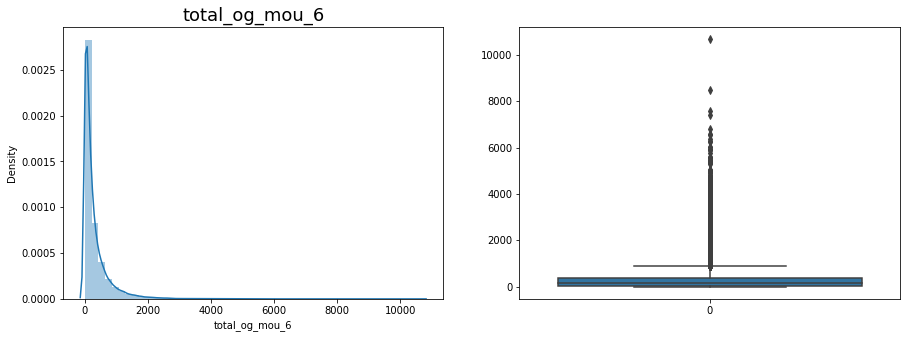

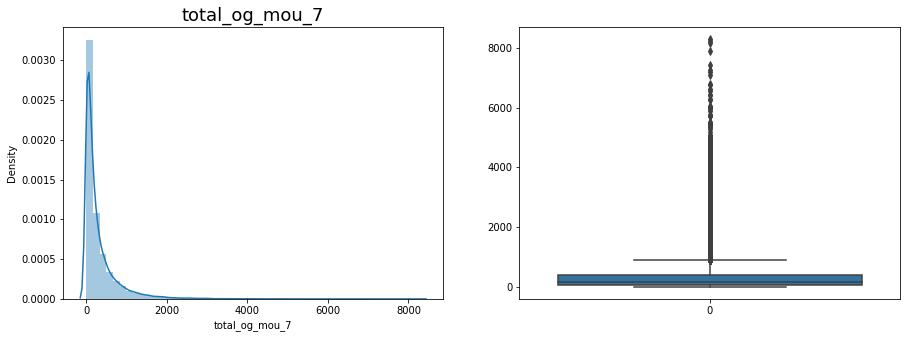

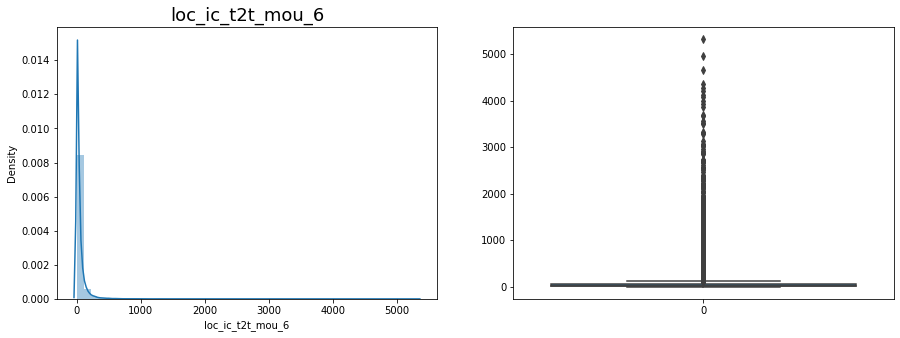

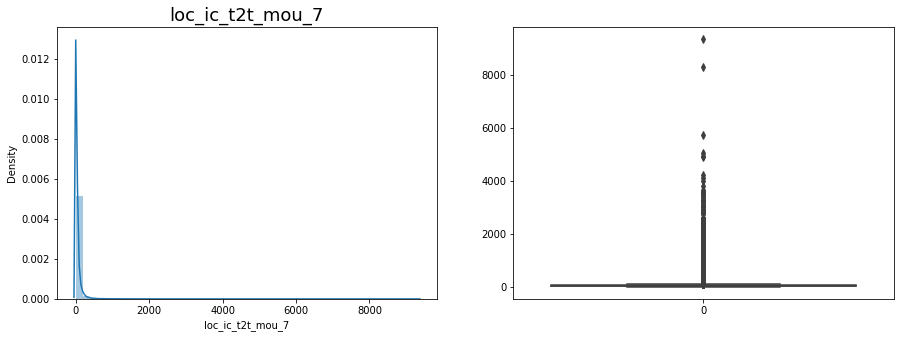

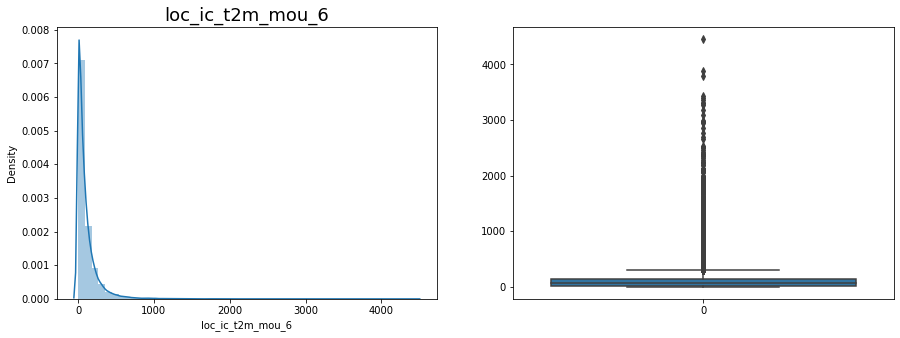

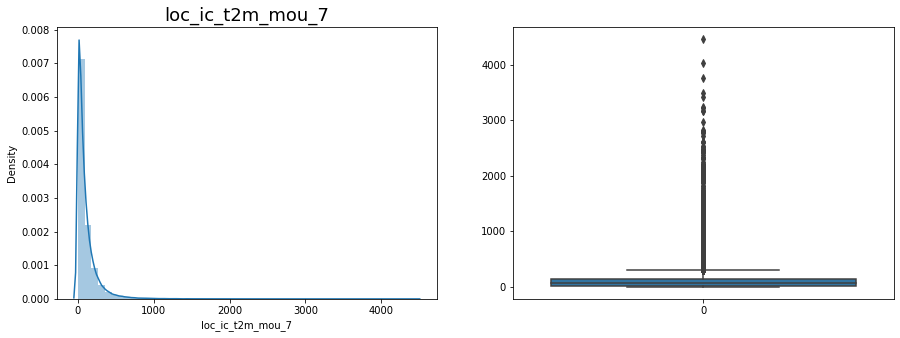

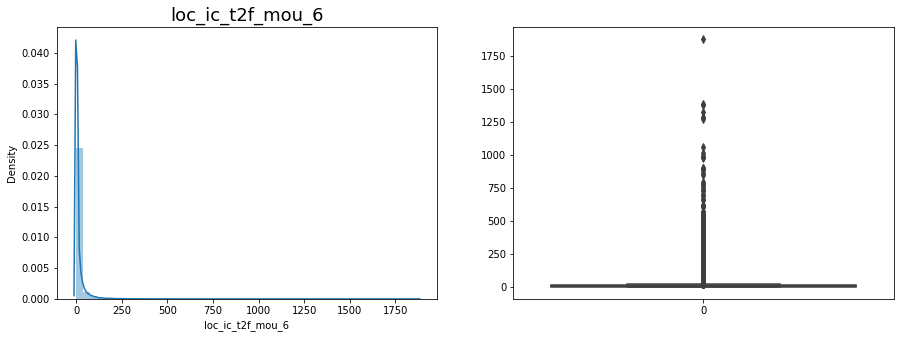

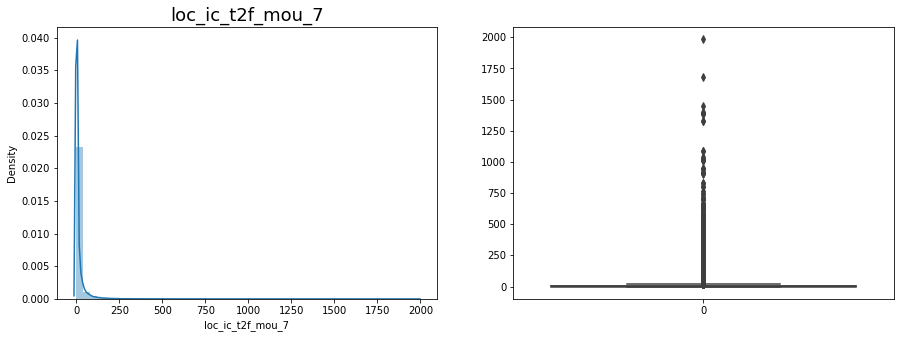

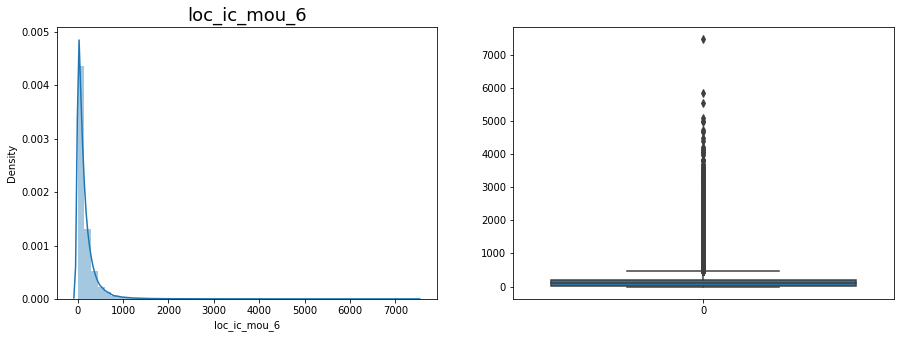

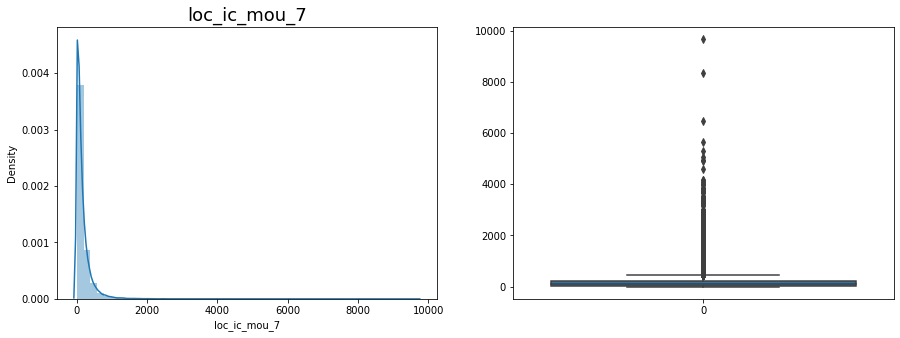

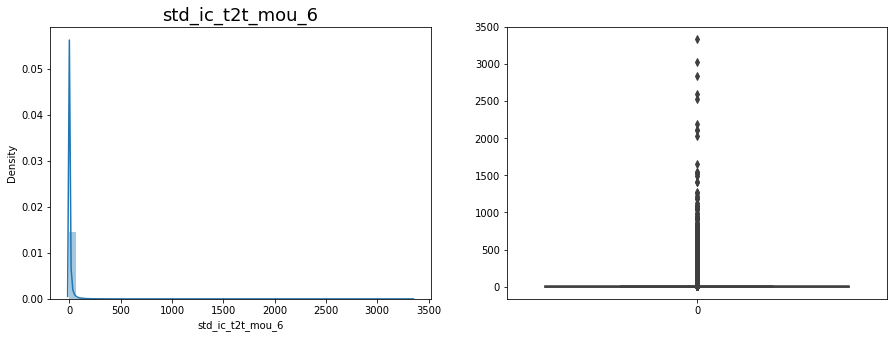

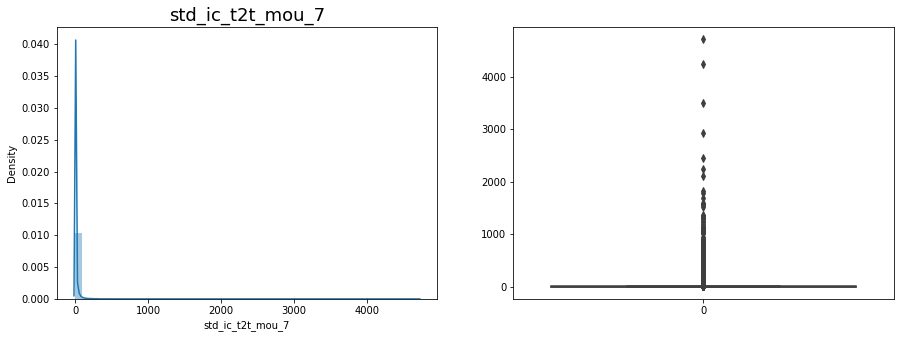

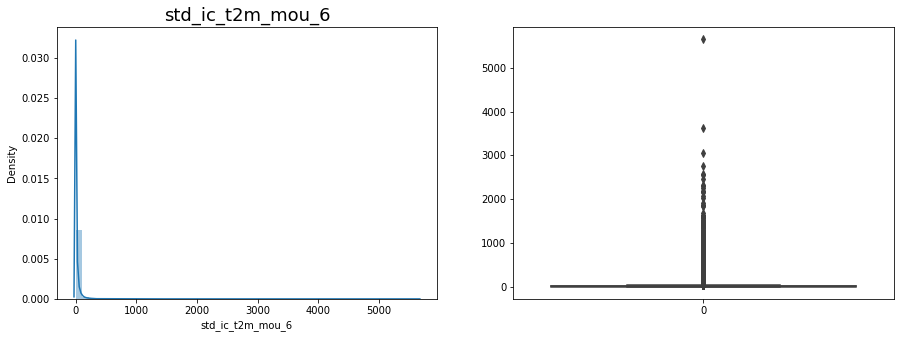

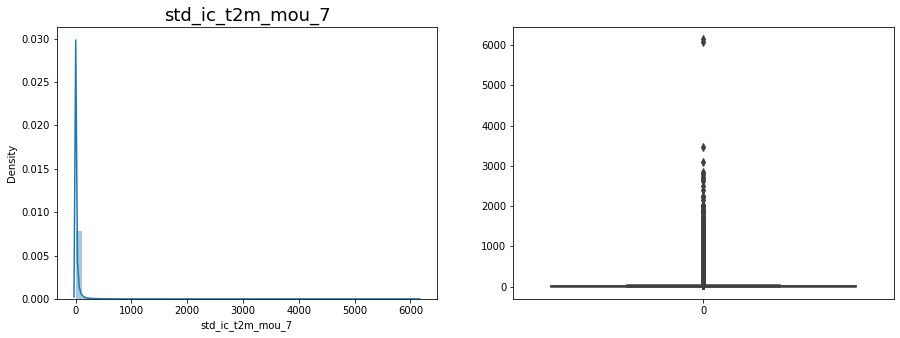

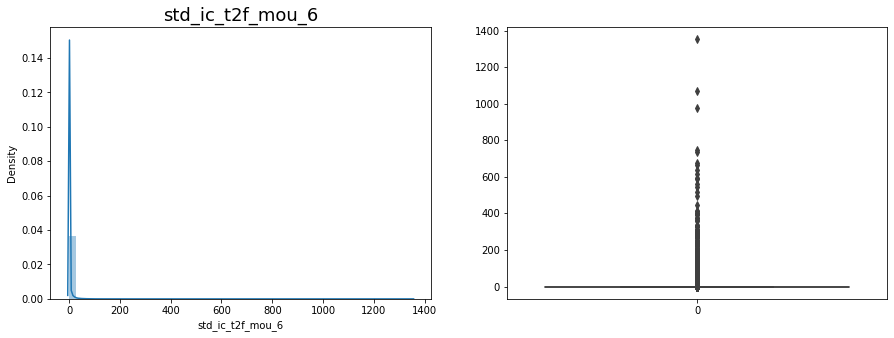

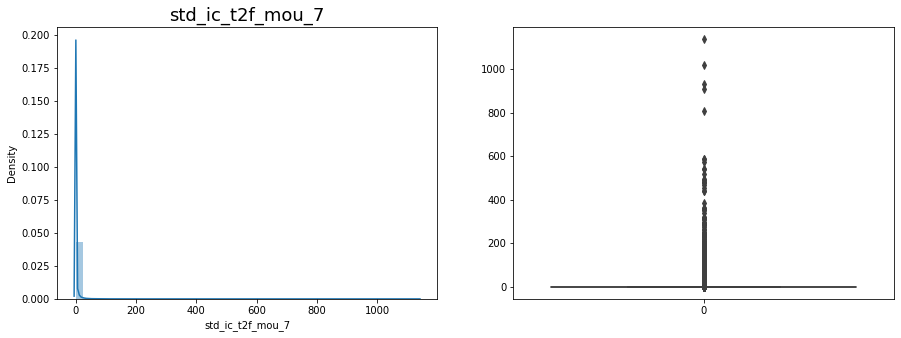

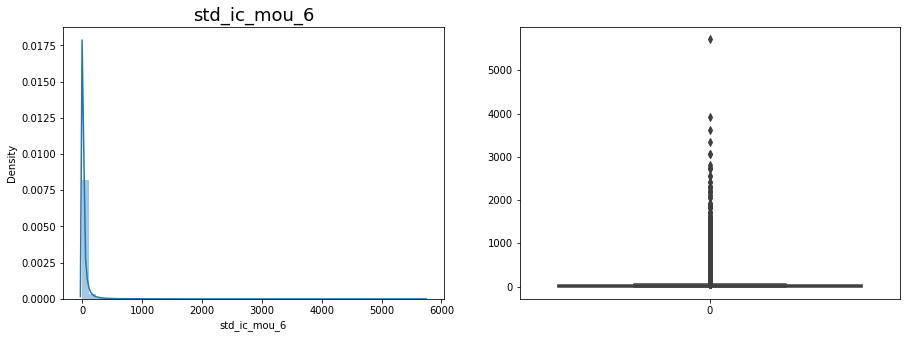

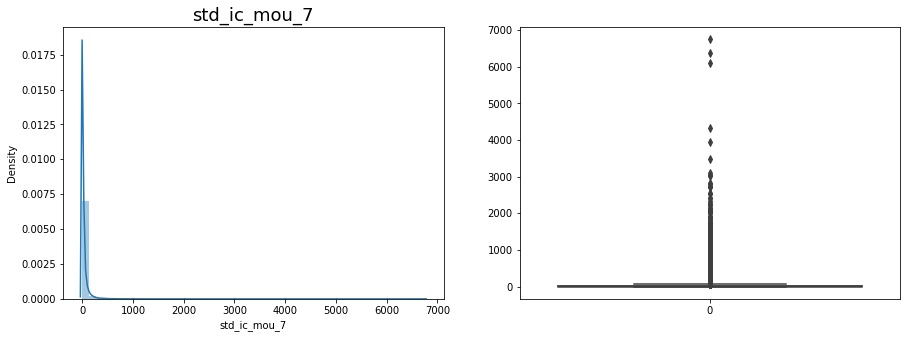

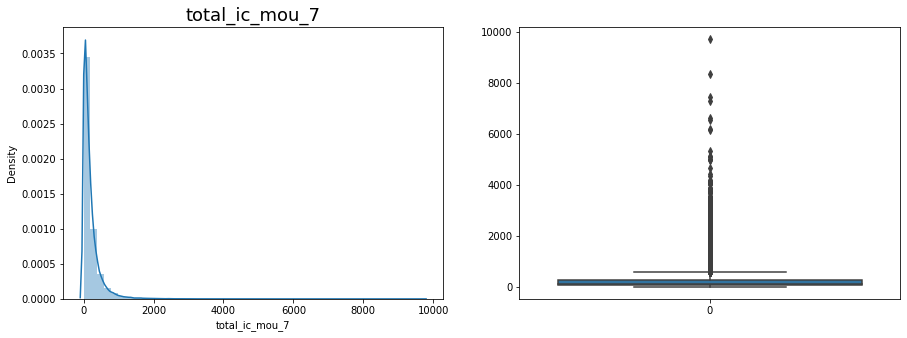

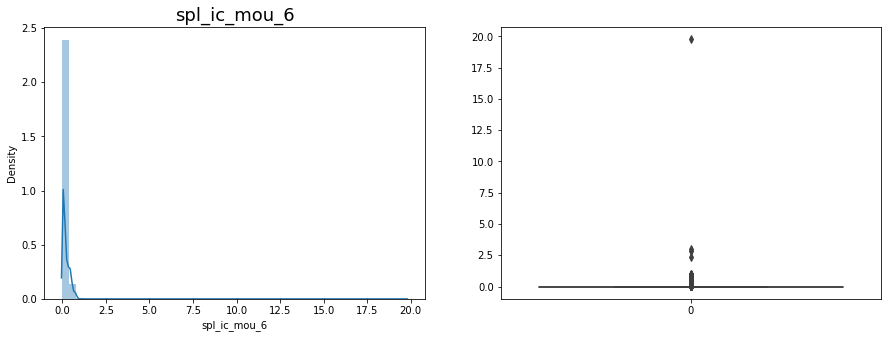

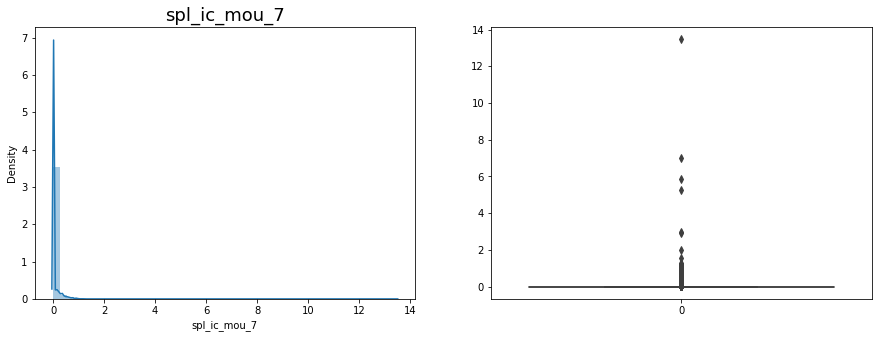

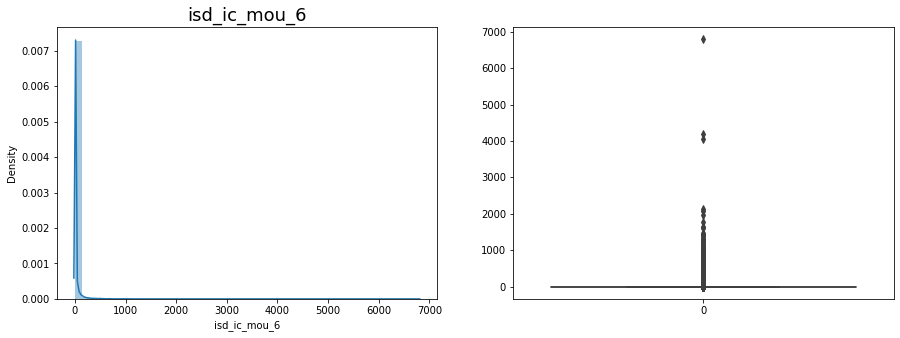

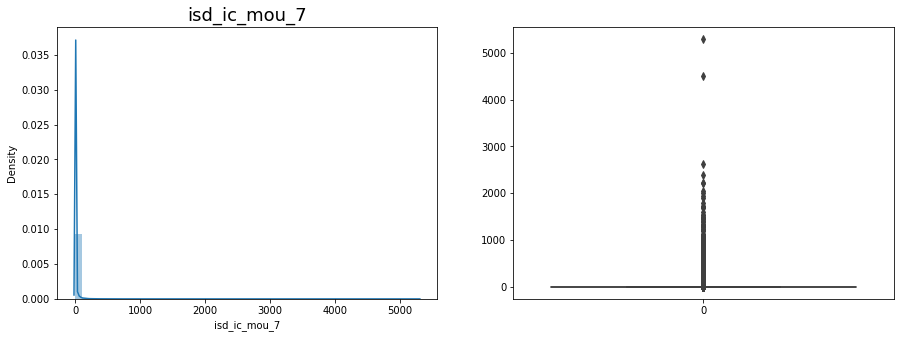

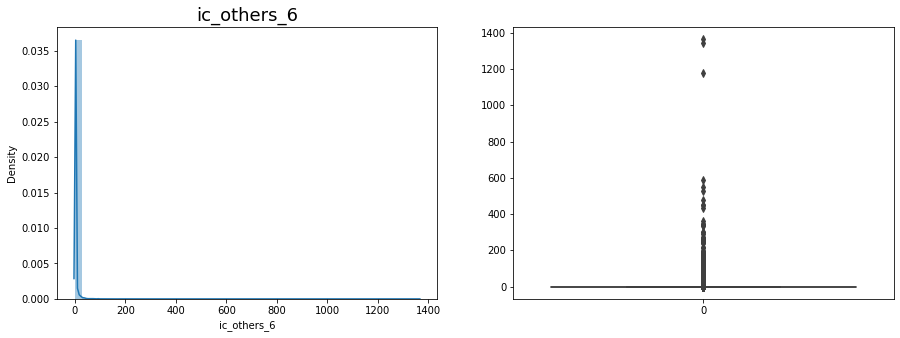

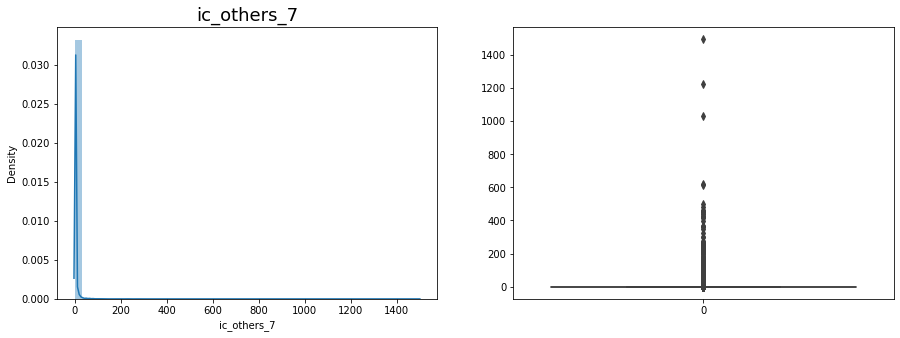

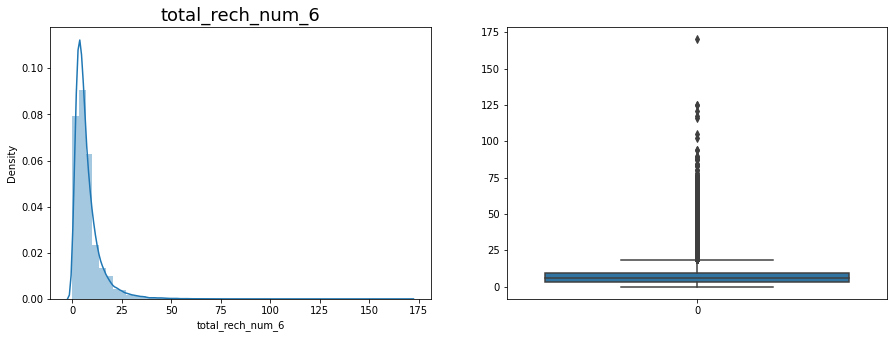

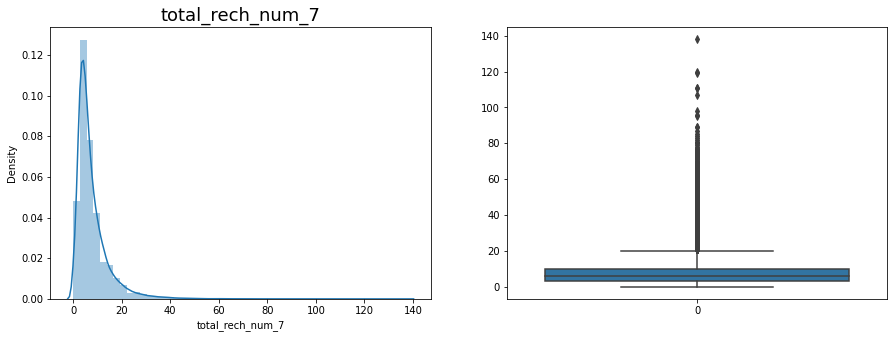

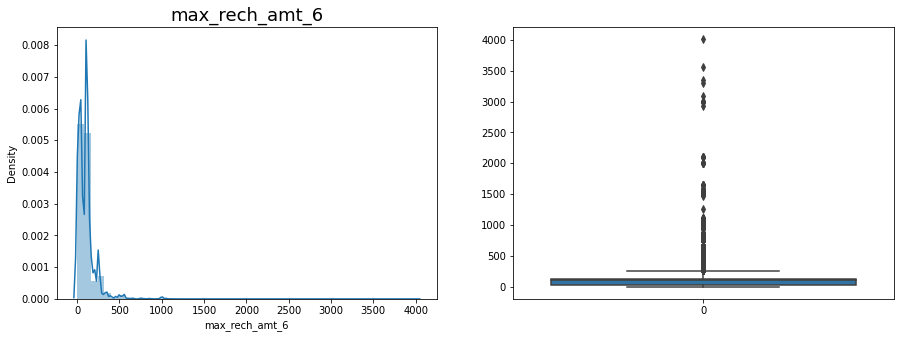

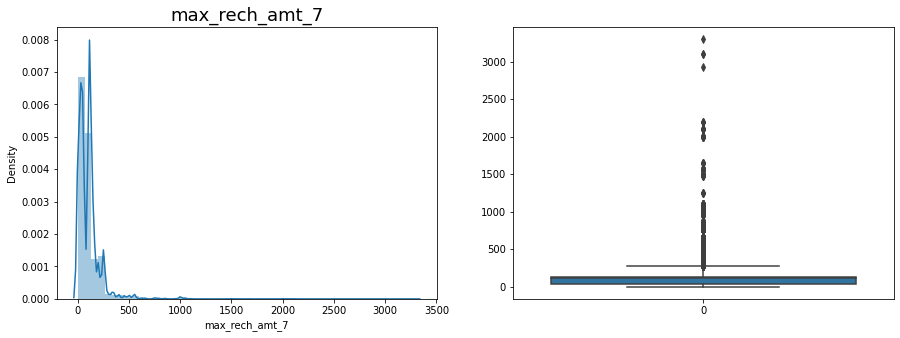

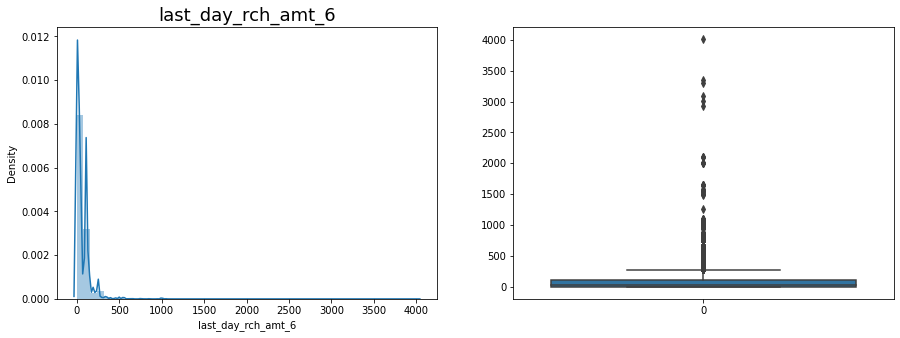

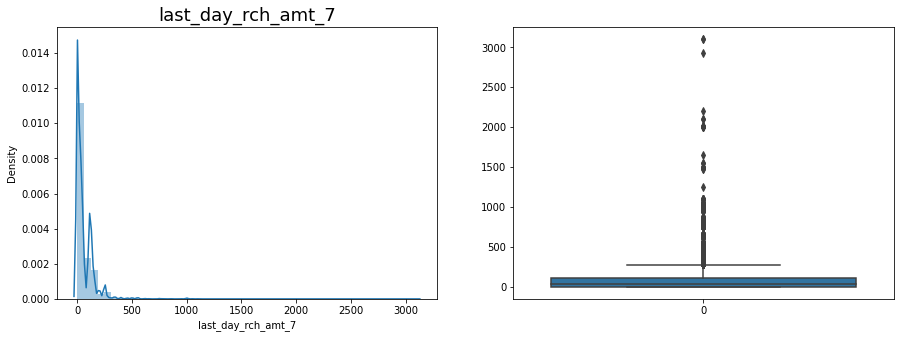

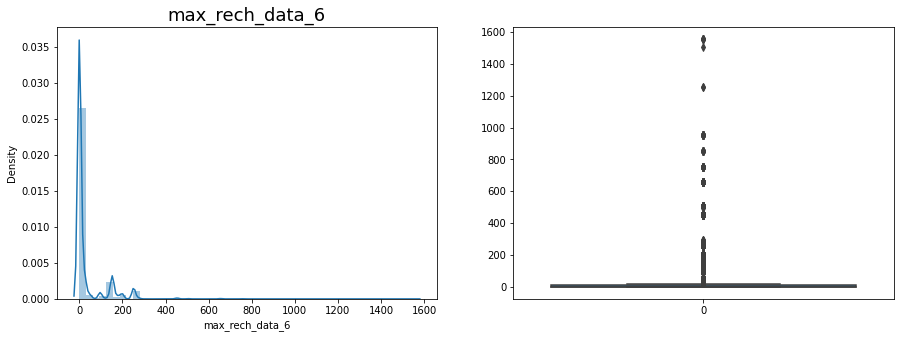

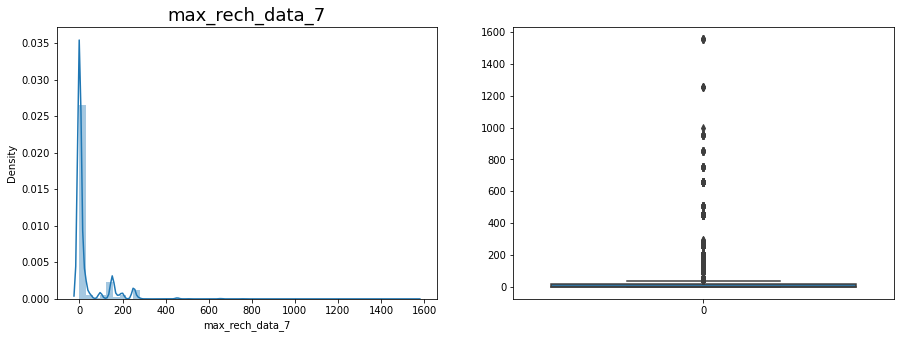

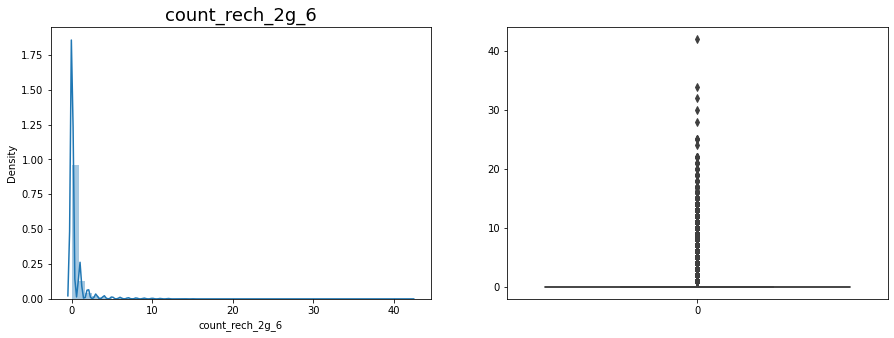

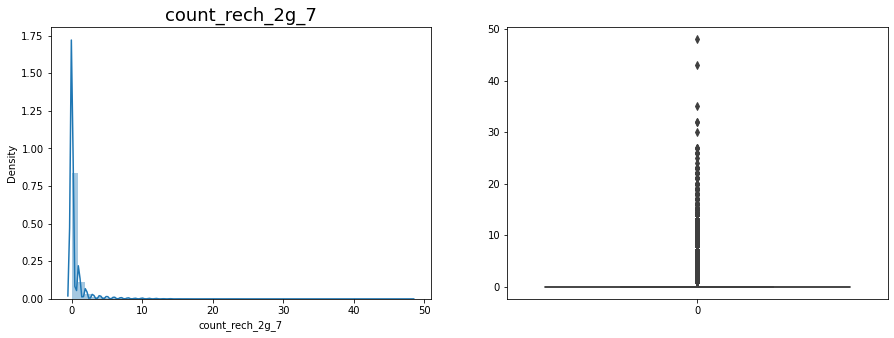

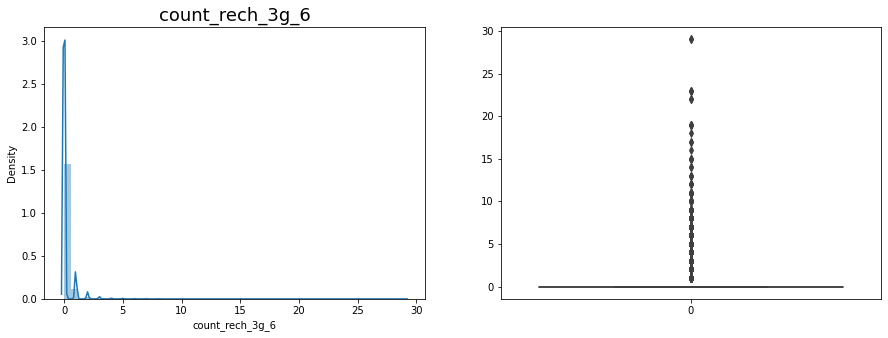

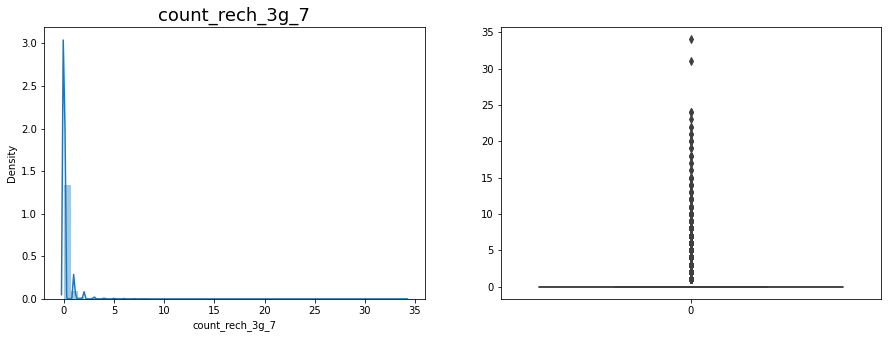

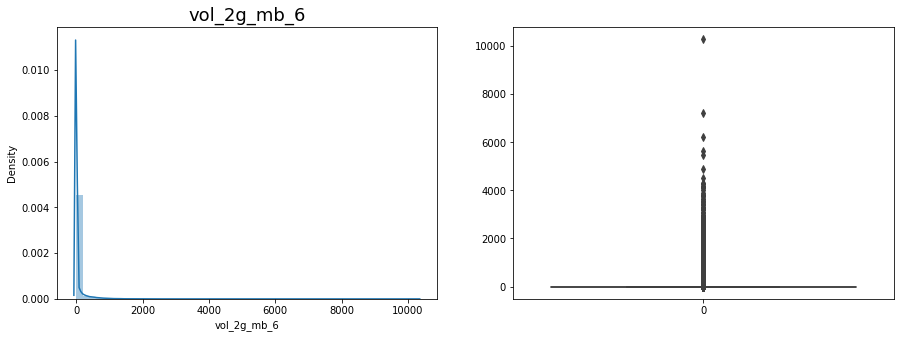

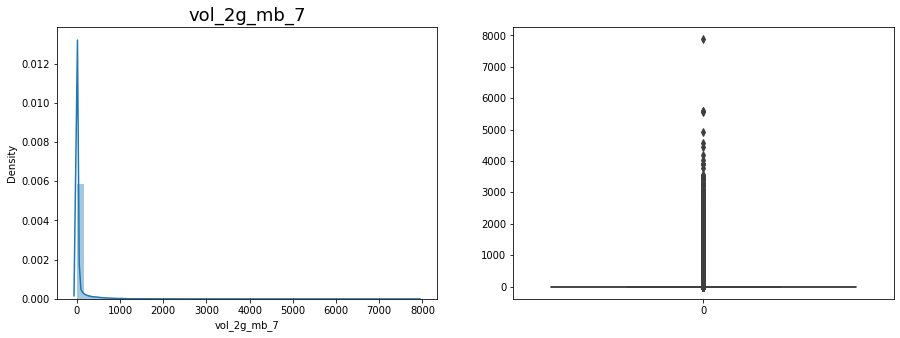

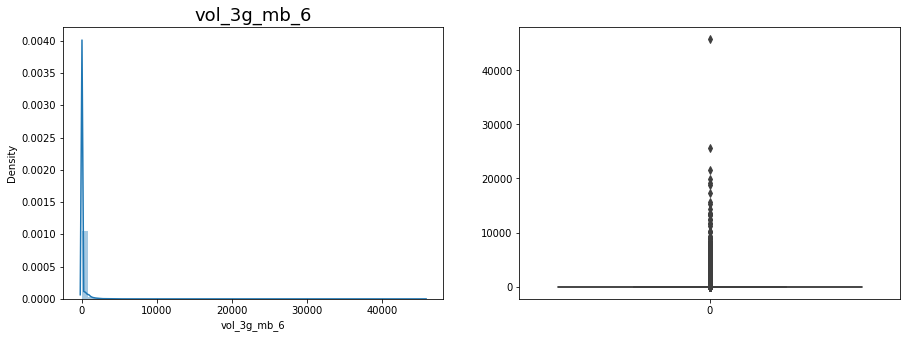

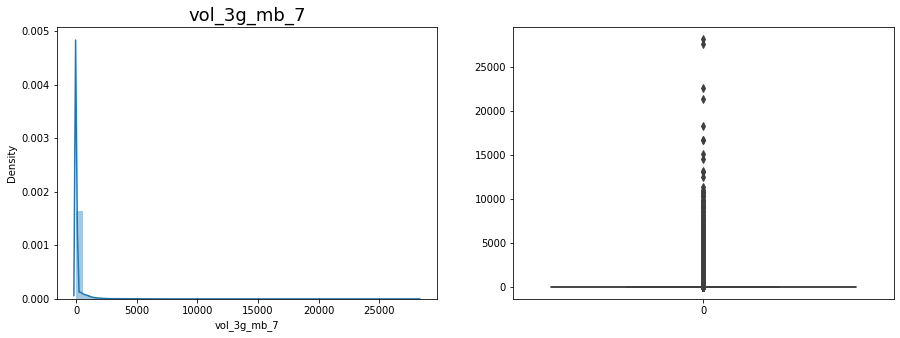

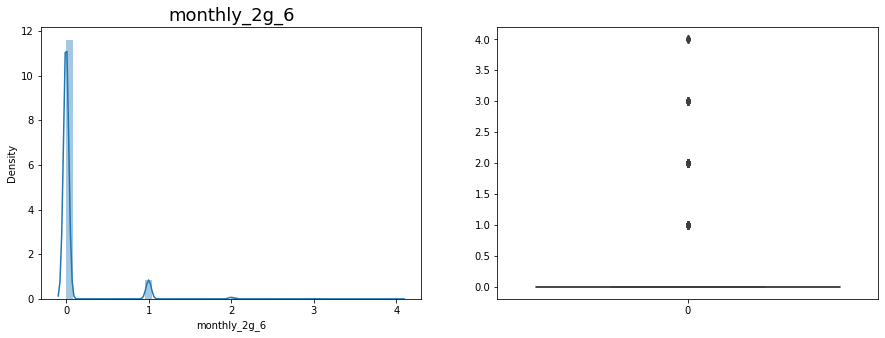

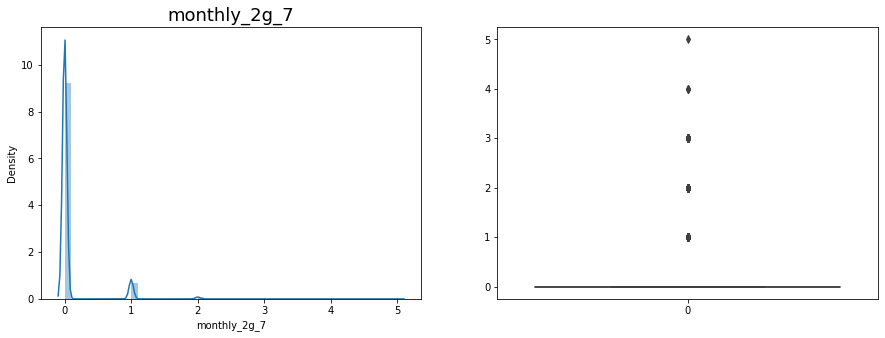

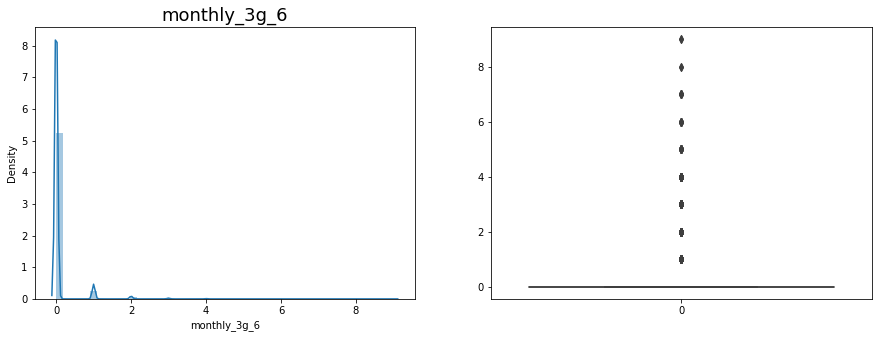

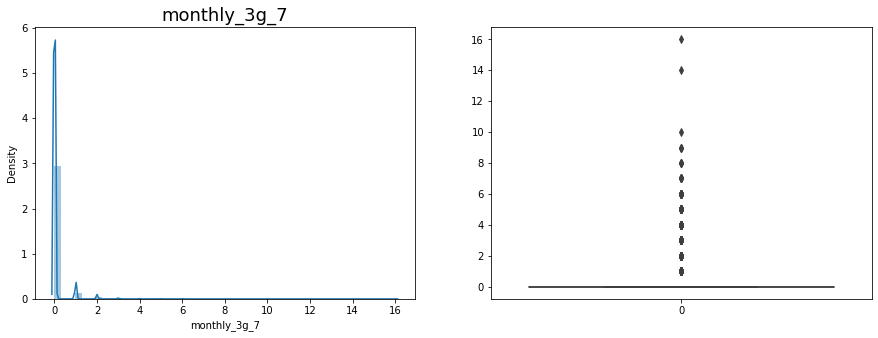

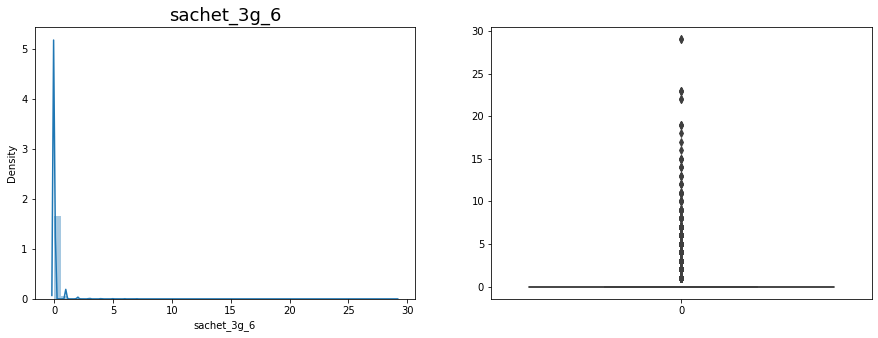

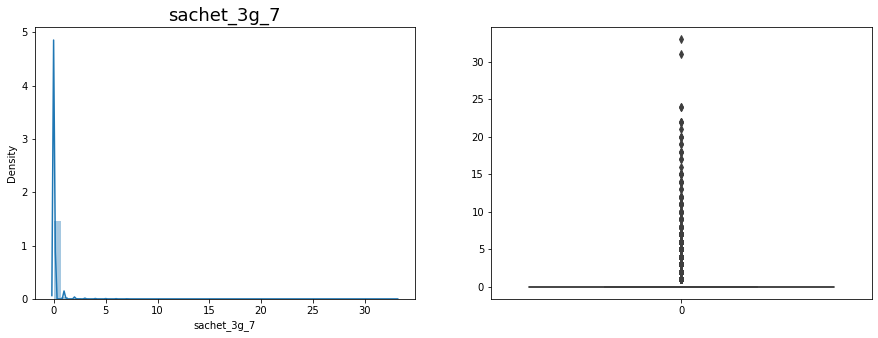

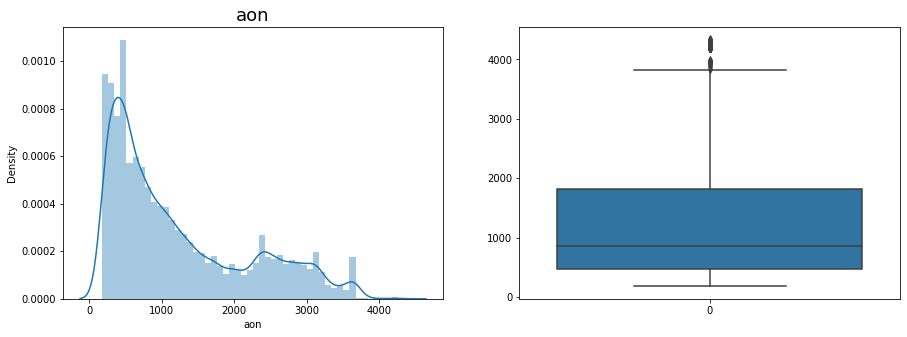

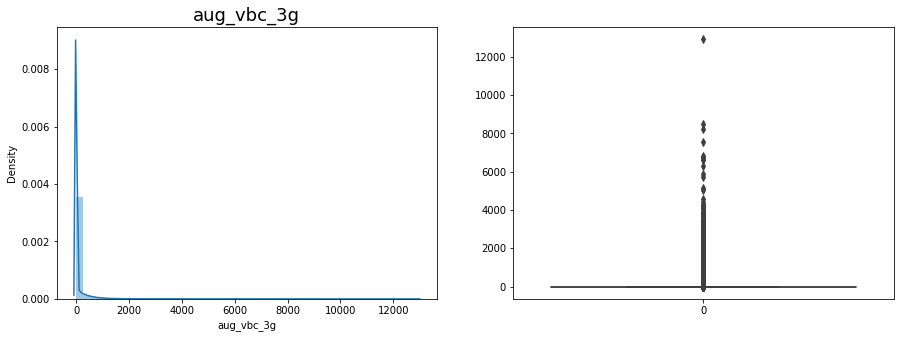

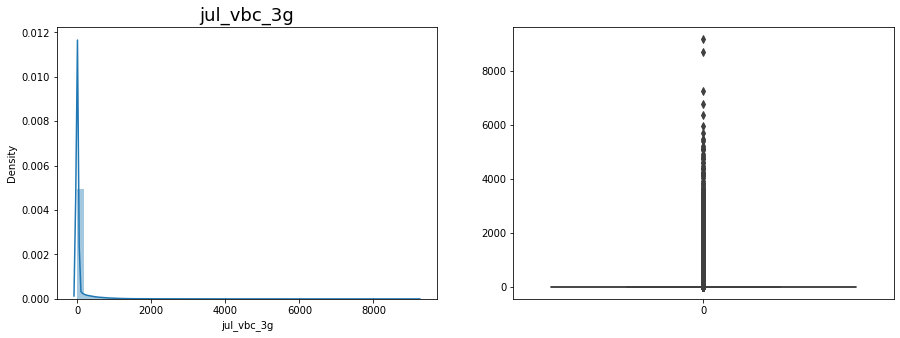

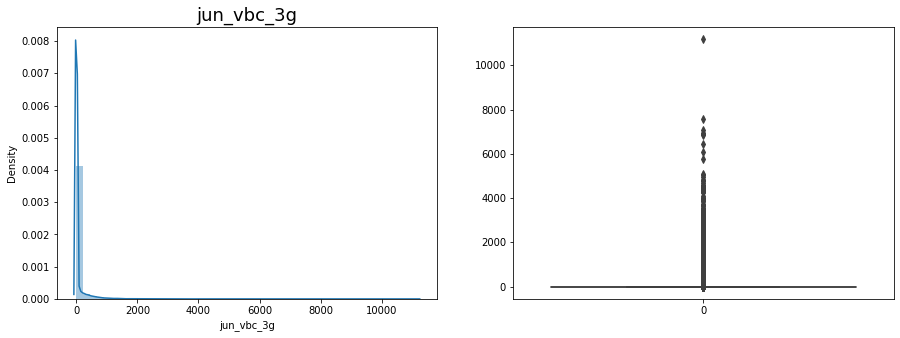

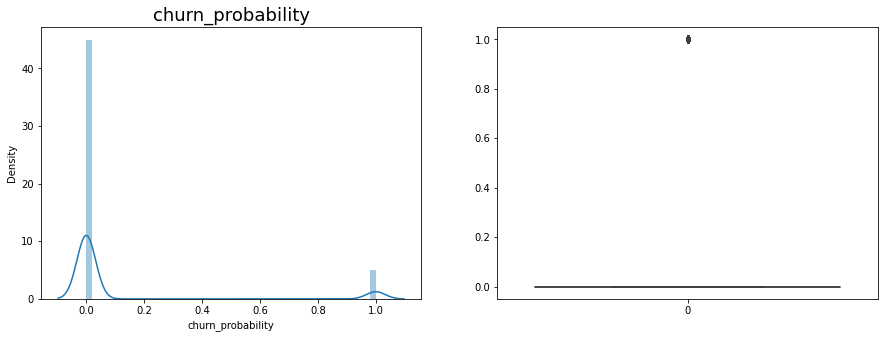

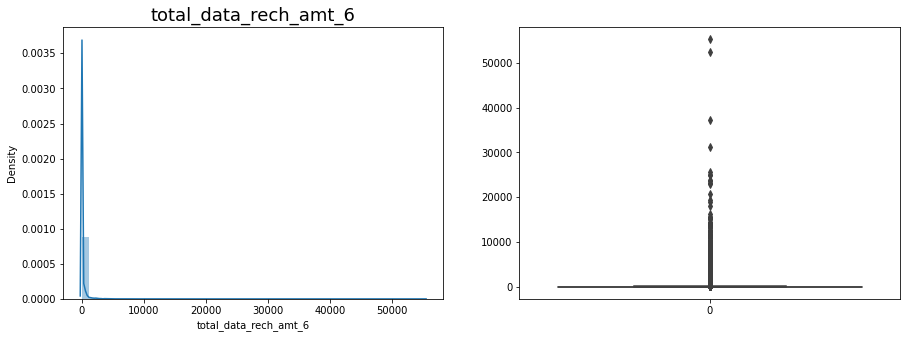

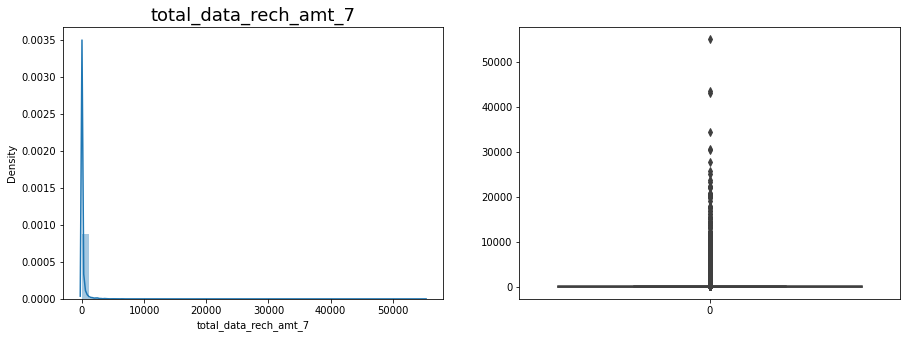

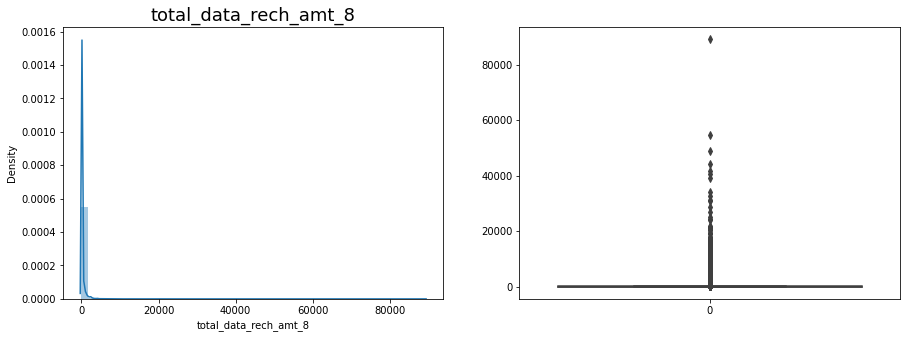

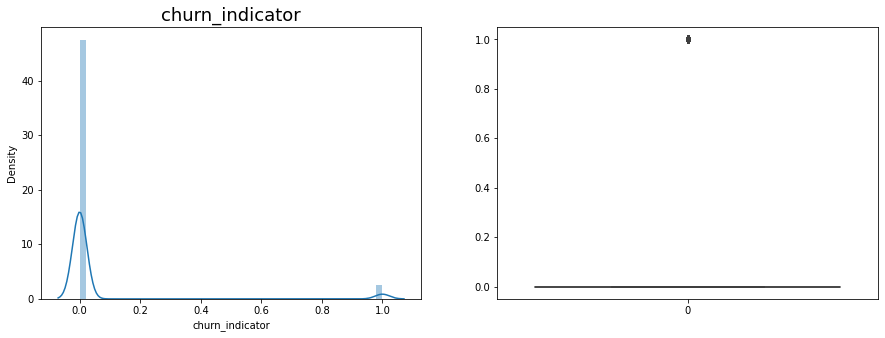

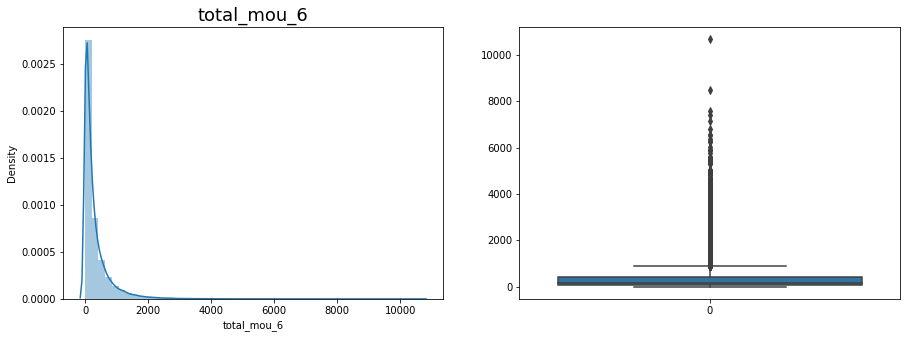

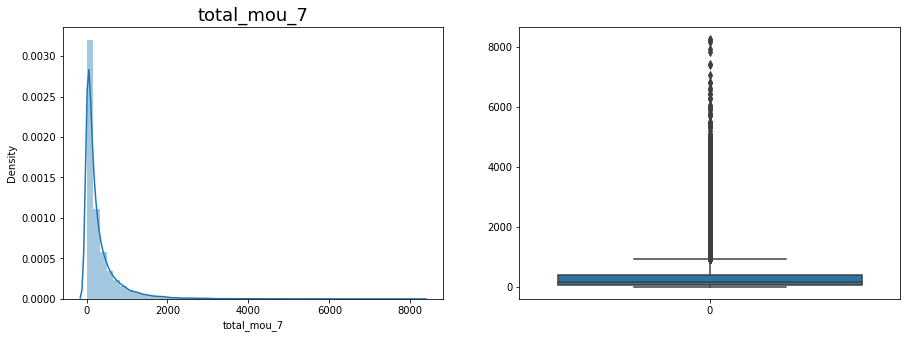

In [268]:
numerical_columns = telecom.select_dtypes(include=['number']).columns
print(numerical_columns)
for col in numerical_columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(telecom[col])
    plt.subplot(1,2,2)
    sns.boxplot(telecom[col])
    plt.show() 

# inference
# from the plots it is clear that most numerical columns have outlier
# need to perform some outlier treatment


Visualise categorical columns

In [269]:
cat_columns = telecom.select_dtypes(include=['object']).columns
cat_columns

# no categorical columns

Index([], dtype='object')

Plot Correlation matrix

In [270]:
# plt.figure(figsize = (50,50))
# sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
# plt.show()

Inference 
- You can see high cor-relation between certain variables.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

# Step 3: Data preparation and processing. 


Outlier Treatment

(69969, 88)
(69969, 88)


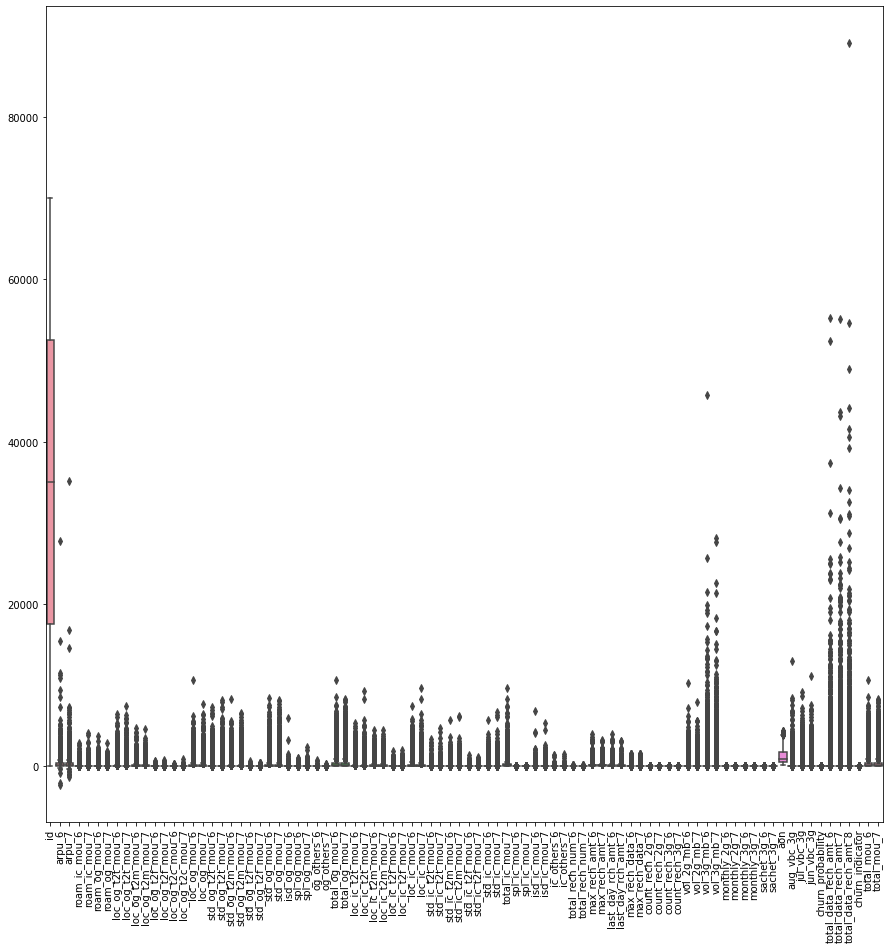

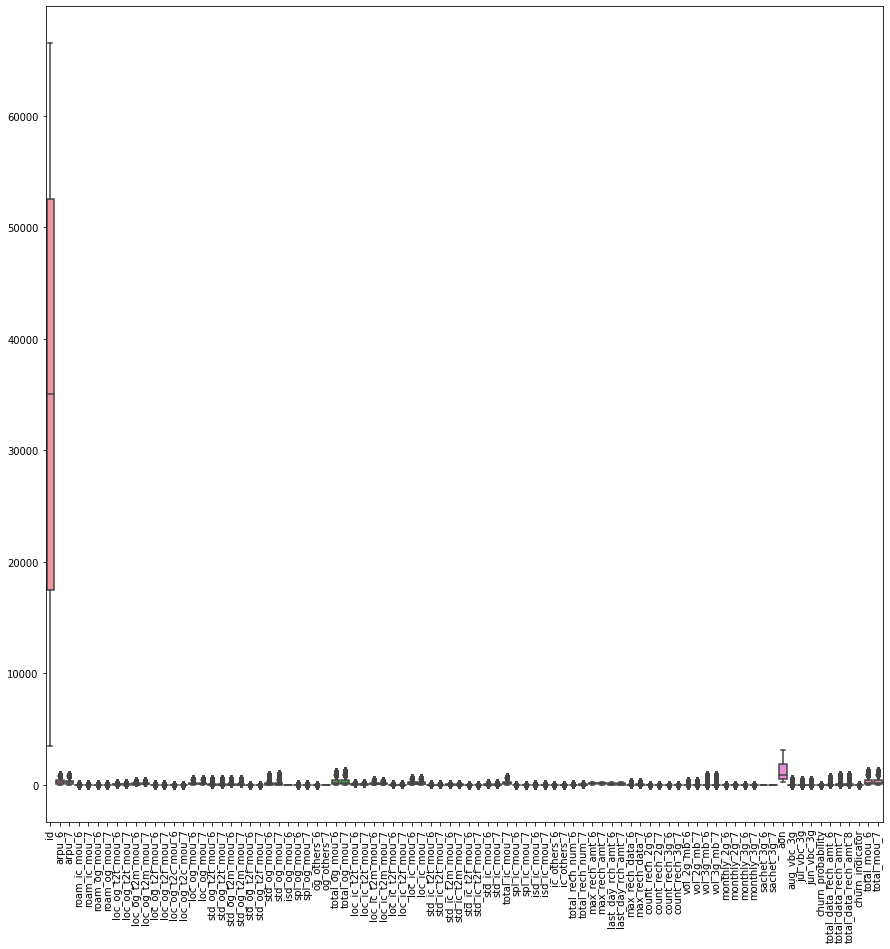

In [271]:
print(telecom.shape)
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);

# keeping values with lower bound a 5% and upper bound as 95%
telecom[numerical_columns] = telecom[numerical_columns].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
# check boxplots again to see if outliers are treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);
print(telecom.shape)

# Outliers have been treated.

#Step 4: Model Building

In [272]:
#round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print(telecom.shape)
telecom = telecom.dropna(axis=0)
print(telecom.shape)

# 2000 rows removed.

(69969, 88)
(65791, 88)


In [273]:
X = telecom.drop(["id", "churn_probability"], axis=1).copy()
X.head()

arpu_6   arpu_7  roam_ic_mou_6  roam_ic_mou_7  roam_og_mou_6  \
0   31.277   87.009           0.00            0.0           0.00   
1    1.500  122.787           0.00            0.0           0.00   
2   60.806  103.176           0.00            0.0           0.00   
3  156.362  205.260           0.00            0.0           0.00   
4  240.708  128.191          41.35            0.0          15.73   

   roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2m_mou_6  \
0            0.0              2.23              0.00              5.29   
1            0.0              0.00              0.00              0.00   
2            0.0              0.53             12.98             24.11   
3            0.0              6.99              3.94             37.91   
4            0.0             10.16              4.83             36.74   

   loc_og_t2m_mou_7  ...     aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  \
0             16.04  ...  1958.0         0.0         0.0         0.0   
1              0.00  ...   710.0         0.0         0.0         0.0   
2              0.00  ...   882.0         0.0         0.0         0.0   
3             44.89  ...   982.0         0.0         0.0         0.0   
4             19.88  ...   647.0         0.0         0.0         0.0   

   total_data_rech_amt_6  total_data_rech_amt_7  total_data_rech_amt_8  \
0                    0.0                    0.0                    0.0   
1                    0.0                  145.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0                    0.0                    0.0   
4                  662.0                  828.0                  828.0   

   churn_indicator  total_mou_6  total_mou_7  
0                0        80.82       221.06  
1                0         0.00        25.99  
2                0        54.52        97.98  
3                0        76.02        94.49  
4                0        78.27        42.94  

[5 rows x 86 columns]

In [274]:
# y = telecom["churn"].copy()
y = telecom["churn_probability"].copy()
y.head()


0    0
1    0
2    0
3    0
4    0
Name: churn_probability, dtype: int64

In [275]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

# xtrain - 52632 rows

(52632, 86)
(52632,)


Scaling

In [276]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [277]:
## Create a scaling instance
scaler = StandardScaler()
## Scale the numerical columns 
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train.describe()

arpu_6        arpu_7  roam_ic_mou_6  roam_ic_mou_7  \
count  5.263200e+04  5.263200e+04   5.263200e+04   5.263200e+04   
mean   3.348051e-17 -5.670086e-17  -3.550554e-17  -6.480098e-18   
std    1.000010e+00  1.000010e+00   1.000010e+00   1.000010e+00   
min   -1.205396e+00 -1.189063e+00  -3.548759e-01  -3.281357e-01   
25%   -7.594261e-01 -7.652162e-01  -3.548759e-01  -3.281357e-01   
50%   -2.903570e-01 -2.945960e-01  -3.548759e-01  -3.281357e-01   
75%    4.838843e-01  4.815883e-01  -3.548759e-01  -3.281357e-01   
max    2.496910e+00  2.487828e+00   3.670269e+00   3.781348e+00   

       roam_og_mou_6  roam_og_mou_7  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   5.263200e+04   5.263200e+04      5.263200e+04      5.263200e+04   
mean   -2.430037e-18  -8.991136e-17      1.927829e-16      3.267049e-17   
std     1.000010e+00   1.000010e+00      1.000010e+00      1.000010e+00   
min    -3.605968e-01  -3.288611e-01     -6.953903e-01     -6.927499e-01   
25%    -3.605968e-01  -3.288611e-01     -6.571117e-01     -6.547984e-01   
50%    -3.605968e-01  -3.288611e-01     -4.389441e-01     -4.377500e-01   
75%    -3.605968e-01  -3.288611e-01      1.767569e-01      1.753372e-01   
max     3.628337e+00   3.743640e+00      2.999339e+00      3.023490e+00   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  ...           aon    aug_vbc_3g  \
count      5.263200e+04      5.263200e+04  ...  5.263200e+04  5.263200e+04   
mean       6.102092e-17      9.720147e-18  ...  4.833073e-17  1.903529e-17   
std        1.000010e+00      1.000010e+00  ...  1.000010e+00  1.000010e+00   
min       -8.290744e-01     -8.308925e-01  ... -1.090865e+00 -3.557547e-01   
25%       -7.216638e-01     -7.182777e-01  ... -8.217052e-01 -3.557547e-01   
50%       -3.969725e-01     -3.978070e-01  ... -3.547291e-01 -3.557547e-01   
75%        3.124956e-01      3.154549e-01  ...  7.327198e-01 -3.557547e-01   
max        2.811609e+00      2.815901e+00  ...  2.021228e+00  3.538074e+00   

         jul_vbc_3g    jun_vbc_3g  total_data_rech_amt_6  \
count  5.263200e+04  5.263200e+04           5.263200e+04   
mean  -1.242019e-16  2.322035e-17           9.463643e-17   
std    1.000010e+00  1.000010e+00           1.000010e+00   
min   -3.479557e-01 -3.394166e-01          -4.311929e-01   
25%   -3.479557e-01 -3.394166e-01          -4.311929e-01   
50%   -3.479557e-01 -3.394166e-01          -4.311929e-01   
75%   -3.479557e-01 -3.394166e-01          -3.515992e-01   
max    3.576497e+00  3.615426e+00           3.332454e+00   

       total_data_rech_amt_7  total_data_rech_amt_8  churn_indicator  \
count           5.263200e+04           5.263200e+04     5.263200e+04   
mean            4.779072e-17          -6.534099e-17     4.613695e-17   
std             1.000010e+00           1.000010e+00     1.000010e+00   
min            -4.261406e-01          -4.291468e-01    -1.834166e-01   
25%            -4.261406e-01          -4.291468e-01    -1.834166e-01   
50%            -4.261406e-01          -4.291468e-01    -1.834166e-01   
75%            -3.472103e-01          -3.223458e-01    -1.834166e-01   
max             3.418226e+00           3.415689e+00     5.452068e+00   

        total_mou_6   total_mou_7  
count  5.263200e+04  5.263200e+04  
mean   2.007480e-16 -1.115117e-16  
std    1.000010e+00  1.000010e+00  
min   -9.038231e-01 -8.818493e-01  
25%   -7.123646e-01 -7.094996e-01  
50%   -3.909075e-01 -4.008869e-01  
75%    3.360167e-01  3.329511e-01  
max    2.727758e+00  2.731339e+00  

[8 rows x 86 columns]

## Logistic Regression Model

Reusable functions for logistic regression

In [315]:
# Let's re-run the model using the selected variables
def build_glm_print_summary(X_train, y_train, col):
  X_train_sm = sm.add_constant(X_train[col])
  logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
  res = logm.fit()
  print(res.summary())
  return res

def glm_predict(model, X_train_sm, y_train):
  # Getting the predicted values on the train set
  y_train_pred = model.predict(X_train_sm)
  print(y_train_pred[:10])
  # creating a df
  y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
  y_train_pred_final['id'] = y_train.index
  print(y_train_pred_final.head())
  y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
  y_train_pred_final.head()
  return y_train_pred_final

def print_confusion_matrix_accuracy(y_train_pred_final):
  # Confusion matrix 
  tn,fp,fn,tp = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted ).ravel()
  print("confusion matrix")
  confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
  print(confusion)
  print(tn,fp,fn,tp)
  # Let's check the overall accuracy.
  print("Accuracy")
  print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
  return confusion

def check_VIF(X_train):
  # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
  vif = pd.DataFrame()
  vif['Features'] = X_train[col].columns
  vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [279]:
# Initial logistic regression model
# Logistic regression model
logm1 = build_glm_print_summary(sm.add_constant(X_train),y_train,numerical_columns)


                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                52632
Model:                            GLM   Df Residuals:                    52549
Model Family:                Binomial   Df Model:                           82
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10642.
Date:                Thu, 30 Mar 2023   Deviance:                       21285.
Time:                        17:10:59   Pearson chi2:                 5.63e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1493
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.13

Feature Selection Using RFE

In [280]:
logreg = LogisticRegression()

In [281]:
rfe = RFE(logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [282]:
rfe.support_

array([ True, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
        True,  True,  True, False, False])

In [283]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 6),
 ('roam_ic_mou_6', False, 24),
 ('roam_ic_mou_7', True, 1),
 ('roam_og_mou_6', False, 43),
 ('roam_og_mou_7', True, 1),
 ('loc_og_t2t_mou_6', False, 13),
 ('loc_og_t2t_mou_7', False, 50),
 ('loc_og_t2m_mou_6', False, 12),
 ('loc_og_t2m_mou_7', False, 21),
 ('loc_og_t2f_mou_6', False, 16),
 ('loc_og_t2f_mou_7', False, 42),
 ('loc_og_t2c_mou_6', False, 67),
 ('loc_og_t2c_mou_7', False, 18),
 ('loc_og_mou_6', False, 11),
 ('loc_og_mou_7', True, 1),
 ('std_og_t2t_mou_6', False, 33),
 ('std_og_t2t_mou_7', False, 60),
 ('std_og_t2m_mou_6', False, 34),
 ('std_og_t2m_mou_7', False, 53),
 ('std_og_t2f_mou_6', False, 46),
 ('std_og_t2f_mou_7', False, 5),
 ('std_og_mou_6', True, 1),
 ('std_og_mou_7', False, 47),
 ('isd_og_mou_6', False, 71),
 ('spl_og_mou_6', False, 56),
 ('spl_og_mou_7', False, 55),
 ('og_others_6', False, 63),
 ('og_others_7', False, 72),
 ('total_og_mou_6', False, 10),
 ('total_og_mou_7', False, 27),
 ('loc_ic_t2t_mou_6', False, 2),

In [284]:
col = X_train.columns[rfe.support_]
col
# predictors selected by RFE
""" 'arpu_6', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_mou_7',
       'std_og_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'spl_ic_mou_6',
       'max_rech_amt_7', 'last_day_rch_amt_7', 'aon', 'aug_vbc_3g',
       'total_data_rech_amt_7', 'total_data_rech_amt_8', 'churn_indicator' """

" 'arpu_6', 'roam_ic_mou_7', 'roam_og_mou_7', 'loc_og_mou_7',\n       'std_og_mou_6', 'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'spl_ic_mou_6',\n       'max_rech_amt_7', 'last_day_rch_amt_7', 'aon', 'aug_vbc_3g',\n       'total_data_rech_amt_7', 'total_data_rech_amt_8', 'churn_indicator' "

In [285]:
X_train.columns[~rfe.support_]
# predictors not selected by RFE

Index(['arpu_7', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_mou_7', 'isd_og_mou_6',
       'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6', 'og_others_7',
       'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_7',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7',
       'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'ic_others_6',
       'ic_others_7', 'total_rech_num_6', 'total_rech_num_7', 'max_rech_amt_6',
       'last_d

##### Assessing the model with StatsModels

In [286]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = build_glm_print_summary(X_train_sm,y_train,col)

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                52632
Model:                            GLM   Df Residuals:                    52616
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10722.
Date:                Thu, 30 Mar 2023   Deviance:                       21444.
Time:                        17:11:31   Pearson chi2:                 5.59e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1467
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.09

In [287]:
# Getting the predicted values on the train set
y_train_pred_final = glm_predict(logm2, X_train_sm, y_train)
y_train_pred_final.head()

21566    0.026783
52501    0.077260
36457    0.011964
53423    0.075297
2810     0.203606
23922    0.023588
8553     0.072698
16984    0.045653
59257    0.052007
4444     0.091755
dtype: float64
       Churn  Churn_Prob     id
21566      0    0.026783  21566
52501      0    0.077260  52501
36457      0    0.011964  36457
53423      1    0.075297  53423
2810       0    0.203606   2810


Churn  Churn_Prob     id  predicted
21566      0    0.026783  21566          0
52501      0    0.077260  52501          0
36457      0    0.011964  36457          0
53423      1    0.075297  53423          0
2810       0    0.203606   2810          0

In [316]:
# Confusion matrix 
confusion = print_confusion_matrix_accuracy(y_train_pred_final)

confusion matrix
[[47994   335]
 [ 2954  1349]]
47994 335 2954 1349
Accuracy
0.9375094999240006


In [289]:
# Predicted     not_churn    churn
# Actual
# not_churn        47994      335
# churn            2954       1349  

  #TP = confusion[1,1] # true positive 
  #TN = confusion[0,0] # true negatives
  #FP = confusion[0,1] # false positives
  #FN = confusion[1,0] # false negatives

## Accuracy 93% - overfitting?

#### Checking VIFs

In [290]:
check_VIF(X_train)

                 Features   VIF
2           roam_og_mou_7  3.31
1           roam_ic_mou_7  3.24
0                  arpu_6  2.66
3            loc_og_mou_7  2.15
4            std_og_mou_6  1.97
8          max_rech_amt_7  1.90
13  total_data_rech_amt_8  1.79
12  total_data_rech_amt_7  1.74
5        loc_ic_t2m_mou_7  1.68
9      last_day_rch_amt_7  1.57
11             aug_vbc_3g  1.47
6        loc_ic_t2f_mou_6  1.21
10                    aon  1.16
14        churn_indicator  1.05
7            spl_ic_mou_6  1.02


In [291]:
# col = col.drop('total_mou_7', 1)
# col= col.drop('std_og_mou_7',1)
# col

In [292]:
# X_train_sm = sm.add_constant(X_train[col])
# logm3 = build_glm_print_summary(X_train_sm,y_train,col)
# # Getting the predicted values on the train set
# y_train_pred_final = glm_predict(logm3, X_train_sm, y_train)
# y_train_pred_final.head()
# confusion = print_confusion_matrix_accuracy(y_train_pred_final)
# check_VIF(X_train)

In [293]:
# dropping loc_og_mou_6 due to high vif
# col = col.drop('loc_og_mou_6', 1)
# col
# # model building
# X_train_sm = sm.add_constant(X_train[col])
# logm4 = build_glm_print_summary(X_train_sm,y_train,col)
# # Getting the predicted values on the train set
# y_train_pred_final = glm_predict(logm4, X_train_sm, y_train)
# print(y_train_pred_final.head())
# print_confusion_matrix_accuracy(y_train_pred_final)
# check_VIF(X_train)

In [294]:
# dropping loc_og_mou_6 due to high vif
# col = col.drop('loc_og_mou_7', 1)
# col
# # model building
# X_train_sm = sm.add_constant(X_train[col])
# logm5 = build_glm_print_summary(X_train_sm,y_train,col)
# # Getting the predicted values on the train set
# y_train_pred_final = glm_predict(logm5, X_train_sm, y_train)
# print(y_train_pred_final.head())
# confusion = print_confusion_matrix_accuracy(y_train_pred_final)
# check_VIF(X_train)

Metrics beyond simply accuracy

In [317]:
def print_other_metrics(confusion):

  TP = confusion[1,1] # true positive TN is TP, FP is FN
  TN = confusion[0,0] # true negatives
  FP = confusion[0,1] # false positives
  FN = confusion[1,0] # false negatives

    
  # Let's see the sensitivity of our logistic regression model
  print('Sensitivity is')
  print(TP / float(TP+FN))
  print('Specificity is')
  print(TN / float(TN+FP))
  print('False Positive Rate is')
  print(FP/ float(TN+FP))
  print('Positive Predictive value is')
  print (TP / float(TP+FP))
  print('Negative Predictive value is')
  print (TN / float(TN+ FN))



In [310]:
print_other_metrics(confusion)

# Sensitivity is
# 0.3135022077620265
# Specificity is
# 0.9930683440584328
# False Positive Rate is
# 0.006931655941567175
# Positive Predictive value is
# 0.8010688836104513
# Negative Predictive value is
# 0.9420193138101594

Sensitivity is
0.9930683440584328
Specificity is
0.3135022077620265
False Positive Rate is
0.6864977922379735
Positive Predictive value is
0.9420193138101594
Negative Predictive value is
0.8010688836104513


In [311]:
print(metrics.classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     48329
           1       0.81      0.34      0.48      4303

    accuracy                           0.94     52632
   macro avg       0.88      0.67      0.73     52632
weighted avg       0.93      0.94      0.93     52632



Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [297]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [298]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

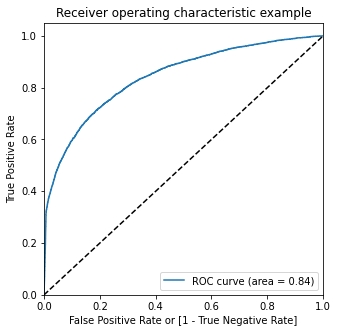

In [299]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

- Let us find the optimal cutoff

- Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [300]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

Churn  Churn_Prob     id  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
21566      0    0.026783  21566          0    1    0    0    0    0    0    0   
52501      0    0.077260  52501          0    1    0    0    0    0    0    0   
36457      0    0.011964  36457          0    1    0    0    0    0    0    0   
53423      1    0.075297  53423          0    1    0    0    0    0    0    0   
2810       0    0.203606   2810          0    1    1    1    0    0    0    0   

       0.7  0.8  0.9  
21566    0    0    0  
52501    0    0    0  
36457    0    0    0  
53423    0    0    0  
2810     0    0    0

In [301]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.081756  1.000000  0.000000
0.1   0.1  0.860104  0.628166  0.880755
0.2   0.2  0.924153  0.430165  0.968135
0.3   0.3  0.934527  0.364165  0.985309
0.4   0.4  0.937396  0.326516  0.991785
0.5   0.5  0.937509  0.313502  0.993068
0.6   0.6  0.936598  0.298629  0.993399
0.7   0.7  0.934774  0.269812  0.993979
0.8   0.8  0.930461  0.204044  0.995137
0.9   0.9  0.921854  0.059029  0.998676


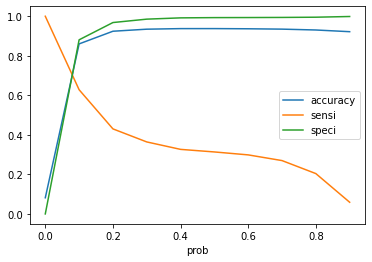

In [302]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()
# from the graph 0.1 is the cutoff

In [303]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_train_pred_final.head()

Churn  Churn_Prob     id  predicted  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
21566      0    0.026783  21566          0    1    0    0    0    0    0    0   
52501      0    0.077260  52501          0    1    0    0    0    0    0    0   
36457      0    0.011964  36457          0    1    0    0    0    0    0    0   
53423      1    0.075297  53423          0    1    0    0    0    0    0    0   
2810       0    0.203606   2810          0    1    1    1    0    0    0    0   

       0.7  0.8  0.9  final_predicted  
21566    0    0    0                0  
52501    0    0    0                0  
36457    0    0    0                0  
53423    0    0    0                0  
2810     0    0    0                1

In [304]:
confusion_final = print_confusion_matrix_accuracy(y_train_pred_final)
print_other_metrics(confusion_final)

# confusion matrix
# [[47994   335]
#  [ 2954  1349]]
# Accuracy
# 0.9375094999240006
# Sensitivity is
# 0.3135022077620265
# Specificity is
# 0.9930683440584328
# False Positive Rate is
# 0.006931655941567175
# Positive Predictive value is
# 0.8010688836104513
# Negative Predictive value is
# 0.9420193138101594

confusion matrix
[[47994   335]
 [ 2954  1349]]
Accuracy
0.9375094999240006
Sensitivity is
0.3135022077620265
Specificity is
0.9930683440584328
False Positive Rate is
0.006931655941567175
Positive Predictive value is
0.8010688836104513
Negative Predictive value is
0.9420193138101594


Prediction on test data

In [305]:
X_test = X_test[col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = logm2.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)
y_test_pred_final.head()

Churn  Churn_Prob  predicted
61191      0    0.005332          0
25993      0    0.087030          0
26711      0    0.014336          0
38227      0    0.070756          0
37810      0    0.041243          0

In [306]:
confusion_test = print_confusion_matrix_accuracy(y_test_pred_final)
print_other_metrics(confusion_test)

# Inference
# confusion matrix
# [[10600  1496]
#  [  392   671]]
# Accuracy
# 0.8565240519796337
# Sensitivity is
# 0.6312323612417686
# Specificity is
# 0.8763227513227513
# False Positive Rate is
# 0.12367724867724868
# Positive Predictive value is
# 0.3096446700507614
# Negative Predictive value is
# 0.9643377001455604

confusion matrix
[[10600  1496]
 [  392   671]]
Accuracy
0.8565240519796337
Sensitivity is
0.6312323612417686
Specificity is
0.8763227513227513
False Positive Rate is
0.12367724867724868
Positive Predictive value is
0.3096446700507614
Negative Predictive value is
0.9643377001455604


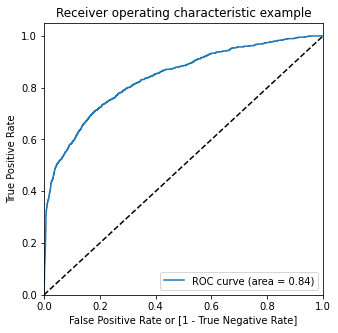

In [307]:
# plotting roc
draw_roc(y_test_pred_final.Churn, y_test_pred_final.Churn_Prob)
# 0.84

In [308]:
# Top 10 predictors

abs(logm2.params).sort_values(ascending=False)[0:11]

# Inference
# const                    3.099396
# total_data_rech_amt_8    0.701871
# churn_indicator          0.670834
# aon                      0.377155
# loc_ic_t2m_mou_7         0.248566
# total_data_rech_amt_7    0.201320
# roam_ic_mou_7            0.197841
# loc_og_mou_7             0.192608
# roam_og_mou_7            0.180941
# arpu_6                   0.172921
# loc_ic_t2f_mou_6         0.152104

const                    3.099396
total_data_rech_amt_8    0.701871
churn_indicator          0.670834
aon                      0.377155
loc_ic_t2m_mou_7         0.248566
total_data_rech_amt_7    0.201320
roam_ic_mou_7            0.197841
loc_og_mou_7             0.192608
roam_og_mou_7            0.180941
arpu_6                   0.172921
loc_ic_t2f_mou_6         0.152104
dtype: float64

Results:

- Logistic regression model has a train accuracy of 93% and test accuracy of 85%.
- The top ten predictors are
    - const                    3.099396
    - total_data_rech_amt_8    0.701871
    - churn_indicator          0.670834
    - aon                      0.377155
    - loc_ic_t2m_mou_7         0.248566
    - total_data_rech_amt_7    0.201320
    - roam_ic_mou_7            0.197841
    - loc_og_mou_7             0.192608
    - roam_og_mou_7            0.180941
    - arpu_6                   0.172921
    - loc_ic_t2f_mou_6         0.152104

## Decision Tree Model

PCA

In [177]:
X.shape


(65791, 86)

In [178]:
y.shape

(65791,)

In [179]:
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X)
X_pca.shape

(65791, 25)

Model building


In [180]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, train_size=0.7, random_state=42)

In [181]:

# Initial classifier
intial_dt = DecisionTreeClassifier(random_state=42, max_depth=10)
intial_dt.fit(X_train, y_train)

# Train Accuracy
y_train_pred = intial_dt.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = intial_dt.predict(X_test)
# Print the report on test data
print( metrics.classification_report(y_test, y_test_pred))

# inference
# train accuracy is 0.93
# test accuracy is 0.91

Train accuracy : 0.9336851019477559
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     18126
           1       0.27      0.07      0.11      1612

    accuracy                           0.91     19738
   macro avg       0.59      0.53      0.53     19738
weighted avg       0.87      0.91      0.88     19738



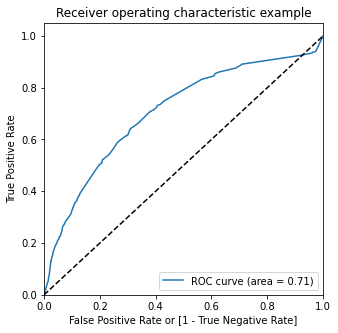

In [182]:
# plot roc

y_test_pred_proba = intial_dt.predict_proba(X_test)
draw_roc(y_test, y_test_pred_proba[:,-1])

Hyperparameter tuning

In [183]:
dt = DecisionTreeClassifier(random_state=42)

# Define parameters
params = {
    "max_depth": [2, 3, 5, 10, 20, 30, 40, 50, 100],
    "min_samples_leaf": [5, 10, 20, 50, 100, 250, 500, 800, 1000],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100]
}

best_dt = run_cross_validation(dt,params,X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'max_depth': 2, 'min_samples_leaf': 1}


In [184]:
best_dt.best_score_

-0.08151477526928985

In [185]:
dt_best = best_dt.best_estimator_
dt_best

## 
# DecisionTreeClassifier(max_depth=2, random_state=42)

DecisionTreeClassifier(max_depth=2, random_state=42)

In [186]:
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)


# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# test accuracy of 92%

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18126
           1       0.00      0.00      0.00      1612

    accuracy                           0.92     19738
   macro avg       0.46      0.50      0.48     19738
weighted avg       0.84      0.92      0.88     19738



In [187]:
y_test_pred_proba = dt_best.predict_proba(X_test)
print('roc_auc_score for DecisionTree: ', metrics.roc_auc_score(y_test, y_test_pred_proba[:,-1]))

roc_auc_score for DecisionTree:  0.6735127679444879


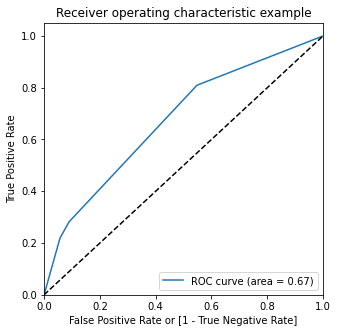

In [188]:
draw_roc(y_test, y_test_pred_proba[:,-1])

Results:

We have a test accuracy of 92% with decision tree

## Random Forest

In [189]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=15, max_depth=10, max_features=5, random_state=42, oob_score=True)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)

# Train Accuracy
y_train_pred = rf.predict(X_train)
print(f'Train accuracy : {metrics.accuracy_score(y_train, y_train_pred)}')

y_test_pred = rf.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))


Train accuracy : 0.9248691724751916
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18126
           1       0.54      0.02      0.03      1612

    accuracy                           0.92     19738
   macro avg       0.73      0.51      0.49     19738
weighted avg       0.89      0.92      0.88     19738



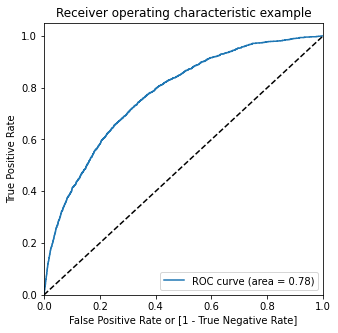

In [190]:
# draw ROC curve
y_test_pred_proba = rf.predict_proba(X_test)
draw_roc(y_test, y_test_pred_proba[:,-1])

Hyperparameter tuning

In [191]:
rf = RandomForestClassifier(random_state=25, n_jobs=-1)

# Define parameters
params = {
    'max_depth': [2, 3, 5, 10, 20, 30],
    'min_samples_leaf': [5, 10, 20, 50],
    'n_estimators': [10, 25, 50]
}

grid_rf = run_cross_validation(rf,params,X_train, y_train, scoring='accuracy')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 50}


In [192]:
grid_rf.best_score_
rf_best = grid_rf.best_estimator_
rf_best

#RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=25,
#                       n_jobs=-1, random_state=25)

RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=25)

In [193]:
y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# accuracy - 92%

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     18126
           1       0.53      0.03      0.05      1612

    accuracy                           0.92     19738
   macro avg       0.72      0.51      0.51     19738
weighted avg       0.89      0.92      0.88     19738



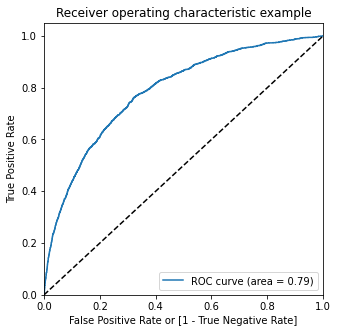

In [194]:
# plot ROC
y_test_pred_proba = rf_best.predict_proba(X_test)
draw_roc(y_test, y_test_pred_proba[:,-1])

#AOC - 79

Results:
- We have test accuracy of 92% with randomforestclassifier

## XG Boost without PCA

In [198]:
# !pip install xgboost
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

(52632, 86)
(52632,)


In [202]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
# fit model on training data with default hyperparameters
model = XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
# use predict_proba since we need probabilities to compute auc
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_proba[:10]

array([[9.9947846e-01, 5.2156718e-04],
       [8.7461114e-01, 1.2538886e-01],
       [9.9170244e-01, 8.2975682e-03],
       [9.1189003e-01, 8.8109992e-02],
       [9.7559500e-01, 2.4404999e-02],
       [9.7349924e-01, 2.6500737e-02],
       [9.5200437e-01, 4.7995616e-02],
       [9.9639761e-01, 3.6023620e-03],
       [9.8166543e-01, 1.8334541e-02],
       [9.9635237e-01, 3.6475980e-03]], dtype=float32)

In [203]:
# evaluate predictions
roc = metrics.roc_auc_score(y_test, y_test_pred_proba[:, 1])
print("AUC: %.2f%%" % (roc * 100.0))

#AUC - 84.69

AUC: 84.69%


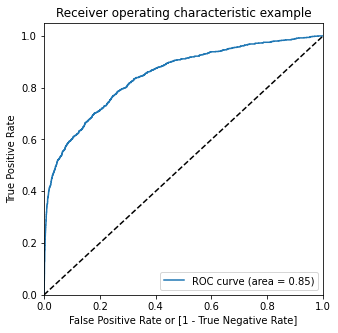

In [204]:
# draw roc
draw_roc(y_test, y_test_pred_proba[:,-1])

#ROC - 0.85

Hyperparameter tuning

In [209]:
# hyperparameter tuning with XGBoost

# specify range of hyperparameters
params = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

grid_xg = run_cross_validation(xgb_model,params,X_train, y_train, scoring='roc_auc')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'learning_rate': 0.2, 'subsample': 0.9}


In [210]:
grid_xg.best_score_

# 0.8588967393669295

0.8588967393669295

In [218]:
grid_xg.best_params_

# {'learning_rate': 0.2, 'subsample': 0.9}

{'learning_rate': 0.2, 'subsample': 0.9}

In [211]:

xg_best = grid_xg.best_estimator_
xg_best

"""XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)"""

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [212]:
y_train_pred = xg_best.predict(X_train)
y_test_pred = xg_best.predict(X_test)


# Print the report
print(metrics.classification_report(y_test, y_test_pred))

# test accuracy of 94%

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12096
           1       0.79      0.34      0.48      1063

    accuracy                           0.94     13159
   macro avg       0.87      0.67      0.72     13159
weighted avg       0.93      0.94      0.93     13159



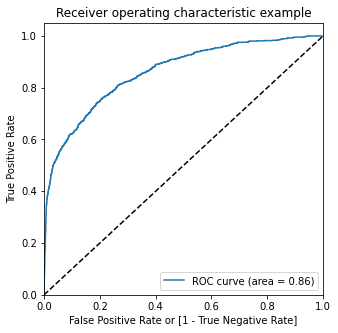

In [220]:
# plot ROC
y_test_pred_proba = xg_best.predict_proba(X_test)
draw_roc(y_test, y_test_pred_proba[:,-1])

# ROC - 0.86

In [234]:
# feature importance
importance = dict(zip(X_train.columns, xg_best.feature_importances_))
importance

{'arpu_6': 0.0061524985,
 'arpu_7': 0.0049904794,
 'roam_ic_mou_6': 0.004216891,
 'roam_ic_mou_7': 0.03541034,
 'roam_og_mou_6': 0.004673197,
 'roam_og_mou_7': 0.07326785,
 'loc_og_t2t_mou_6': 0.005040845,
 'loc_og_t2t_mou_7': 0.0043550674,
 'loc_og_t2m_mou_6': 0.004249079,
 'loc_og_t2m_mou_7': 0.0059573604,
 'loc_og_t2f_mou_6': 0.0043076645,
 'loc_og_t2f_mou_7': 0.010068564,
 'loc_og_t2c_mou_6': 0.0030533134,
 'loc_og_t2c_mou_7': 0.0063650664,
 'loc_og_mou_6': 0.004139605,
 'loc_og_mou_7': 0.005368753,
 'std_og_t2t_mou_6': 0.009191359,
 'std_og_t2t_mou_7': 0.0051667574,
 'std_og_t2m_mou_6': 0.006213388,
 'std_og_t2m_mou_7': 0.003249882,
 'std_og_t2f_mou_6': 0.0060221995,
 'std_og_t2f_mou_7': 0.0029329052,
 'std_og_mou_6': 0.03165974,
 'std_og_mou_7': 0.022091215,
 'isd_og_mou_6': 0.0,
 'spl_og_mou_6': 0.0034614517,
 'spl_og_mou_7': 0.007766145,
 'og_others_6': 0.0027990257,
 'og_others_7': 0.0,
 'total_og_mou_6': 0.0042245956,
 'total_og_mou_7': 0.006234224,
 'loc_ic_t2t_mou_6': 0.003

In [235]:
import operator

sorted_important_features = sorted(importance.items(),key=operator.itemgetter(1),reverse=True)
sorted_important_features

[('churn_indicator', 0.26712242),
 ('roam_og_mou_7', 0.07326785),
 ('loc_ic_mou_7', 0.06975542),
 ('total_ic_mou_7', 0.05102215),
 ('loc_ic_t2f_mou_7', 0.04199629),
 ('roam_ic_mou_7', 0.03541034),
 ('std_og_mou_6', 0.03165974),
 ('total_data_rech_amt_8', 0.026479773),
 ('aon', 0.025107624),
 ('total_data_rech_amt_6', 0.022886973),
 ('std_og_mou_7', 0.022091215),
 ('loc_ic_mou_6', 0.013878124),
 ('vol_2g_mb_7', 0.012600982),
 ('loc_og_t2f_mou_7', 0.010068564),
 ('std_og_t2t_mou_6', 0.009191359),
 ('loc_ic_t2t_mou_7', 0.008322218),
 ('spl_og_mou_7', 0.007766145),
 ('count_rech_2g_7', 0.007317955),
 ('loc_ic_t2f_mou_6', 0.0072710025),
 ('isd_ic_mou_7', 0.007085831),
 ('loc_og_t2c_mou_7', 0.0063650664),
 ('total_og_mou_7', 0.006234224),
 ('std_og_t2m_mou_6', 0.006213388),
 ('arpu_6', 0.0061524985),
 ('std_og_t2f_mou_6', 0.0060221995),
 ('loc_og_t2m_mou_7', 0.0059573604),
 ('max_rech_amt_7', 0.005890655),
 ('loc_ic_t2m_mou_7', 0.005542338),
 ('total_rech_num_6', 0.005452485),
 ('loc_og_mou_

In [229]:
# Scatter plot 
trace = go.Scatter(
    y = xg_best.feature_importances_,
    x = X.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1.3,
        size = 12,
        color = xg_best.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'GBM Model Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 5,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter')

In [238]:
# confusion metrics and other metrics
conf = metrics.confusion_matrix(y_test, y_test_pred )
conf

#array([[11998,    98],
#       [  701,   362]])

array([[11998,    98],
       [  701,   362]])

In [239]:
# print other metrics
print_other_metrics(conf)

#Sensitivity is
#0.3405456255879586
#Specificity is
#0.9918981481481481
#False Positive Rate is
#0.008101851851851851
#Positive Predictive value is
#0.7869565217391304
#Negative Predictive value is
#0.9447988030553587

Sensitivity is
0.3405456255879586
Specificity is
0.9918981481481481
False Positive Rate is
0.008101851851851851
Positive Predictive value is
0.7869565217391304
Negative Predictive value is
0.9447988030553587


In [240]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     12096
           1       0.79      0.34      0.48      1063

    accuracy                           0.94     13159
   macro avg       0.87      0.67      0.72     13159
weighted avg       0.93      0.94      0.93     13159



Results:
- We have test accuracy of 94%
- Recall 0.99
- ROC - 0.86

Features selected by XGBoost
 -'churn_indicator', 0.26712242,
 -'roam_og_mou_7', 0.07326785,
 -'loc_ic_mou_7', 0.06975542,
 -'total_ic_mou_7', 0.05102215,
 -'loc_ic_t2f_mou_7', 0.04199629,
 -'roam_ic_mou_7', 0.03541034,
 -'std_og_mou_6', 0.03165974,
 -'total_data_rech_amt_8', 0.026479773,
 -'aon', 0.025107624,
 -'total_data_rech_amt_6', 0.022886973,


In [ ]:
## Feature selection
- Logistic regresssion selected the below ten features
        - const                    3.099396
        - total_data_rech_amt_8    0.701871
        - churn_indicator          0.670834
        - aon                      0.377155
        - loc_ic_t2m_mou_7         0.248566
        - total_data_rech_amt_7    0.201320
        - roam_ic_mou_7            0.197841
        - loc_og_mou_7             0.192608
        - roam_og_mou_7            0.180941
        - arpu_6                   0.172921
        - loc_ic_t2f_mou_6         0.152104
- XGBoost selected the below features
         -'churn_indicator', 0.26712242,
         -'roam_og_mou_7', 0.07326785,
         -'loc_ic_mou_7', 0.06975542,
         -'total_ic_mou_7', 0.05102215,
         -'loc_ic_t2f_mou_7', 0.04199629,
         -'roam_ic_mou_7', 0.03541034,
         -'std_og_mou_6', 0.03165974,
         -'total_data_rech_amt_8', 0.026479773,
         -'aon', 0.025107624,
         -'total_data_rech_amt_6', 0.022886973,
        
- Selecting the best out of both, we can see that
        - 'churn_indicator' - derived metric based on the usage from the last month is a predictor.
        - 'total_data_rech_amt_8'
        - 'aon'
        - 'roam_ic_mou_7'
        - 'roam_og_mou_7'
        

In [ ]:
## Model Selection

# Logistic Regression
    - Metrics on test data
        - Accuracy = 
        - Sensitivity =
        - Specificity =
        - False Positive Rate =
        - Positive Predictive Rate =
        - Negative Predictive Rate =
        - ROC =
        
# Decision Tree
    - Metrics on test data
        - Accuracy = 
        - Sensitivity =
        - Specificity =
        - False Positive Rate =
        - Positive Predictive Rate =
        - Negative Predictive Rate =
        - ROC =
# Random Forest
    - Metrics on test data
        - Accuracy = 
        - Sensitivity =
        - Specificity =
        - False Positive Rate =
        - Positive Predictive Rate =
        - Negative Predictive Rate =
        - ROC =
# XGBoost
    - Metrics on test data
        - Accuracy = 0.94
        - Sensitivity = 0.3405456255879586
        - Specificity = 0.9918981481481481
        - False Positive Rate = 0.008101851851851851
        - Positive Predictive Rate = 0.7869565217391304
        - Negative Predictive Rate = 0.9447988030553587
        - ROC = 0.86
        
        
